<a href="https://colab.research.google.com/github/jojoroy/MScDis/blob/main/Copy_of_small_params_GPMH_penalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building some intuition about the $L^2$ based risk approach.

The general idea is the following:  we employ a surrogate GP model for the log likelihood of a positive density $\pi$, i.e.
we assume that
$$
    \pi_f(x) = \frac{\exp(f(x))\pi_0(x)}{\int \exp(f(x'))\pi_0(x')\,dx'}.
$$
where $\pi_0$ is a prior distribution which is assumed to be tractable.   We denote by $\widetilde{\pi}_f$ to be the unnormalised posterior distribution.

#### Approach 1:  $L^2$ between unnormalised measures loss.

This is the idea of [Sinsbeck and Nowak](https://epubs.siam.org/doi/abs/10.1137/15M1047659), however it has been adjusted to make it comparable to our approach.  While in their paper they considered a surrogate for the actual forward problem, in this work we surrogate the likelihood directly.   This is directly discussed in [Jarvenpaa et al, 2021](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-1/Parallel-Gaussian-Process-Surrogate-Bayesian-Inference-with-Noisy-Likelihood-Evaluations/10.1214/20-BA1200.full), although the focus of that paper is an alternative loss function.   

We wish to derive an optimal estimator for the unnormalised posterior $\widetilde{\pi}_f$ using Bayesian decision theory.  To this end, we consider the integrated quadratic loss function:
$$
    l(\widetilde{\pi}_1, \widetilde{\pi}_2) = \int_{X} |\widetilde{\pi}_1(x) - \widetilde{\pi}_2(x)|^2\,dx,
$$
where we assume that both $\widetilde{\pi}_1$ and $\widetilde{\pi}_2$ are square-integrable.

The optimal bayes estimator is the minimiser of the expected loss, i.e.
$$
\begin{aligned}
    \widetilde{\pi}^* &= \arg\min_{d} \mathbb{E}_{f| D} \int |\widetilde{\pi}_f(x) - d(x)|^2\,dx \\
                      &= \arg\min_{d}  \int \mathbb{E}_{f| D} |\widetilde{\pi}_f(x) - d(x)|^2\,dx
\end{aligned}
$$
The optimal estimator can be derived and shown to be
$$
    \widetilde{\pi}^* =  \mathbb{E}_{f| D}[\widetilde{\pi}_f].
$$

The Bayes risk is the integrated variance;
$$
\int {Var}_{f | D}[\widetilde{\pi}_f(x)]\,dx.
$$

You can derive closed-form expressions for both in the GP case, namely
$$
   \mathbb{E}_{f| D}[\widetilde{\pi}_f] = \pi_0(x)e^{m(x) + s^2(x)},
$$
and
$$
 {Var}_{f | D}[\widetilde{\pi}_f(x)] = \pi_0(x)^2 e^{2m(x) + s^2(x)}(e^{s^2(x)} - 1),
$$
where $m$ and $s$ are the pointwise mean and standard deviation of the conditioned GP $f | D$.  

#### Approach 2: $L^2$ between the scores.

Ultimately, we want the surrogate model to perform MCMC.  If we're using a gradient based approach, then only really care about the score function, i.e. the gradient of the log likelihood.   It makes sense to consider a loss function which is only penalising errors in the gradient -- this has a lot of advantages:  we no longer have to worry about the normalisation constant, and it simplifies some calculations significantly.

We consider an optimal estimator for the score function $\nabla \log \pi_f$, i.e.
$$
    l(\widetilde{\pi}_1, \widetilde{\pi}_2) = \int |\nabla \log \widetilde{\pi}_1(x) - \nabla \log \widetilde{\pi}_2(x)|^2.
$$
The optimal estimator is then
$$
\begin{aligned}
    \widetilde{\pi}^* &= \arg\min_{d} \mathbb{E}_{f| D} \int |\nabla \log\widetilde{\pi}_f(x) - \nabla \log d(x)|^2\,dx \\
                      &= \arg\min_{d}  \int \mathbb{E}_{f| D} |\nabla \log \widetilde{\pi}_f(x) - \nabla \log d(x)|^2\,dx
\end{aligned}
$$
The optimal estimator then satisfies
$$
\nabla \log \widetilde{\pi}^*(x) = \nabla \mathbb{E}_{f | D } f(x) = \nabla  m(x),
$$
so that
$$
    \widetilde{\pi}^*(x) \propto e^{m(x)}.
$$
The risk / variance of the estimator is
$$
    \mathbb{E}_{f|D}\int |\nabla \log \pi_f(x) - \nabla m(x)|^2 \,dx =  \mathbb{E}_{f|D}\int |\nabla f(x)- \nabla m(x)|^2 \,dx,
$$
which is
$$
    \int Tr(Cov(\nabla f(x) |D))\,dx = \int \nabla_1 \cdot \nabla_2 k_{D}(x, x)\,dx.
$$
The most important point is that this term is independent of the evaluations of the true posterior.  This means that no active learning is feasible in this instance, and instead we would do a single offline point evaluation stage.


#### Approach 3: Distances between the measures

An alternative approach which constrasts with the local one considered previously, would be to require that the estimator is close to the surrogate in terms of distances on probability distributions.  For example, we could use KL divergence.

Consider
$$
\begin{aligned}
 \mathbb{E}_{f|D}l(\pi_f, d) &= \mathbb{E}_{f|D}KL(d, \pi_f) \\
 &=  \int d(x) \log d(x)\,dx - \int d(x) m_n(x)\,dx,
 \end{aligned}
$$
using the fact that $\int d(x)\,dx = 1$.  This has minimiser:
$$
d^*(x) \propto e^{m_n(x)}
$$

The risk is
$$
\mathbb{E}_{f|D}KL(d^*, \pi_f) = \int\frac{ e^{m_n(x)}}{Z_n}  m_n(x)\,dx - \int \frac{e^{m_n(x)}}{Z_n} m_n(x)\,dx = 0.
$$

(Am I making a mistake here?  This seems unlikely to be true?)

Alternatively, we could consider the Reverse-KL as a loss
$$
\begin{aligned}
 \mathbb{E}_{f|D}l(\pi_f, d) &= \mathbb{E}_{f|D}KL(\pi_f, d) \\
 &=   \mathbb{E}_{f|D}\left[\int \pi_f \log \pi_f\,dx - \int \pi_f \log d(x)\,dx\right], \\
 &=   \int \mathbb{E}_{f|D}[\pi_f \log \pi_f]\,dx - \int \mathbb{E}_{f|D}[\pi_f] \log d(x) \,dx, \\
 &= C +  \int \mathbb{E}_{f|D}[\pi_f] \log \mathbb{E}_{f|D}[\pi_f]\,dx - \int \mathbb{E}_{f|D}[\pi_f] \log d(x) \,dx, \\
 &= C + KL(\mathbb{E}_{f|D}[\pi_f] , d),
 \end{aligned}
$$
where $C$ is a constant.  The optimal estimator is therefore
$$
d^* = \mathbb{E}_{f|D}[\pi_f].
$$

### Our Proposed Approach

We propose the following iterative scheme

Find $p_n$ such that
$$
    \arg\max_{x} \mathbb{E}_{z \sim f(x)|D}\mathbb{E}_{f|D }D(p_{D \cup \lbrace (x,y)\rbrace } \,|\, p_{D})
$$
Choosing KL divergence we have objective function
$$
\mathbb{E}_{z \sim f(x)|D} \mathbb{E}_{f|D }\int \frac{e^{f_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{f_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$

With Fisher divergence, we get a similar expression, but with gradients in the integrand.   If we can argue that we can replace $f$ with it's mean, then this simplifies somewhat:
$$
\mathbb{E}_{z \sim f(x)|D} \int \frac{e^{m_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{m_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$
It is unclear how we can justify this assumption, and further how to cleanly deal with the expectation wrt to $z$.

### Exploring the $L^2$ loss based estimator and its risk.   

We implement the idea of Sinsbeck and Nowak, but adjust it to work in our setting where we have a surrogate for the likelihood directly.

tlk about removing new points
two point covar not working
tuning proposal

In [ ]:
pip install jaxtyping


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
pip install gpjax==0.8.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.2/197.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.24.0
    Uninstalling tensorflow-probability-0.24.0:
      Successfully uninstalled tensorflow-probability-0.24.0
  Attempting uninstall: optax
    Found existing installation: optax 0.2.2
    Uninstalling optax-0.2.2:
      Successfully uninstalled optax-0.2.2


In [ ]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

from jax.scipy.special import logsumexp
from jax.scipy.stats import norm as norm
import cola


key = jr.PRNGKey(123)

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [ ]:
import numpy as np
#from jax.scipy.special import log1p

This is just some test code to check that the Gaussian process does regression properly. lets check in 1d. tolerance test points 10^3. evaluating over a grid 10^3

In [ ]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [ ]:
# Define the negative log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll = jit(negative_mll)

def fit_gp(x,y, key, do_optimize=True, obs_stddev=1e-3):
    """Fit a GP to the data (x,y) using the negative log marginal likelihood as the objective function.
    Args:
        x: input data
        y: output data
        key: random key
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        posterior: the posterior distribution
    """

    D = gpx.Dataset(x, y)

    kernel = gpx.kernels.RBF()
    meanf = gpx.mean_functions.Zero()
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

    likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=obs_stddev)
    posterior = prior * likelihood

    if do_optimize:
        # optimize the hyperparameters using Adam (this isn't great, but it works)
        # TODO: use a better optimizer
        # the optimizer needs optax to work
        opt_posterior, _ = gpx.fit(
        model=posterior,
        objective=negative_mll,
        num_iters=1000,
        train_data=D,
        optim=ox.adamw(learning_rate=0.01),
        key = key)

        return opt_posterior
    else:
        return posterior


def evaluate_posterior(x,y, x_eval, key, do_optimize=True, obs_stddev=1e-3):
    """Evaluate the posterior predictive distribution at x_eval.
    Args:
        x: input data
        y: output data
        x_eval: points at which to evaluate the posterior predictive distribution
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        predictive_mean: mean of the posterior predictive distribution
        predictive_std: standard deviation of the posterior predictive distribution
    """

    D = gpx.Dataset(x, y)

    posterior = fit_gp(x,y, key, do_optimize=do_optimize, obs_stddev=obs_stddev)


    latent_dist = posterior.predict(x_eval, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    return predictive_mean, predictive_std

In [ ]:
# Define the negative log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll = jit(negative_mll)

def fit_gp(x,y, key, do_optimize=True, obs_stddev=1e-3):
    """Fit a GP to the data (x,y) using the negative log marginal likelihood as the objective function.
    Args:
        x: input data
        y: output data
        key: random key
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        posterior: the posterior distribution
    """

    D = gpx.Dataset(x, y)

    kernel = gpx.kernels.RBF()
    meanf = gpx.mean_functions.Zero()
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

    likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n,obs_stddev=jnp.array(1e-3))  # Our function is noise-free, so we set the observation noise's standard deviation to a very small value
    likelihood = likelihood.replace_trainable(obs_stddev=False)
    posterior = prior * likelihood

    if do_optimize:
        # optimize the hyperparameters using Adam (this isn't great, but it works)
        # TODO: use a better optimizer
        # the optimizer needs optax to work
        opt_posterior, a = gpx.fit(
        model=posterior,
        objective=negative_mll,
        num_iters=1000,
        train_data=D,
        optim=ox.adamw(learning_rate=0.01),safe=True,
        key = key)

        return opt_posterior
    else:
        return posterior


def evaluate_posterior(x,y, x_eval, key, do_optimize=True, obs_stddev=1e-3):
    """Evaluate the posterior predictive distribution at x_eval.
    Args:
        x: input data
        y: output data
        x_eval: points at which to evaluate the posterior predictive distribution
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        predictive_mean: mean of the posterior predictive distribution
        predictive_std: standard deviation of the posterior predictive distribution
    """

    D = gpx.Dataset(x, y)

    posterior = fit_gp(x,y, key, do_optimize=do_optimize, obs_stddev=obs_stddev)


    latent_dist = posterior.predict(x_eval, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    return predictive_mean, predictive_std

To select a new point, Sinsbeck and Nowak make use of the L2 risk function (also Jarvenpaa et al, 2021), as follows:

$$
    R(\theta^*) = \mathbb{E}_{y \sim f(x^*) |D}\int e^{2m_t(x; x^*, y) + s_t^2(x; x^*, y)}(e^{s_t^2(x; x^*, y)} - 1),
$$
where $m_t(x; x^*, y)$ is the posterior mean of the GP after conditioning on the current data set $D$ along with an additional point $(x^*, y)$.  The variance $s_t^2(x; x^*, y)$ is defined analogously.

To compute the expectation, we do Monte Carlo using exact samples of $y \sim f(x^*) |D$.  We typically use just $10$ samples.  Unsurprisingly this is very slow, and little bit unstable.

To compute the integral over $x$, we evaluate the gp over a fine mesh and use Euler integration.   This obviously cannot scale beyond a few dimensions.

So can we avoid the need to compute the expectation with respect to y?   

To do so, we follow the approach / derivations in [Jarvenpaa, 2021] which derive closed form distributions for the GP mean and GP variance.  

More specifically we can show that the loss function becomes
$$
        R(\theta^*) = \int e^{2m_t(x) + s_t^2(x)}(e^{\tau_t(x, x^*)} - 1),
$$
where
$$
\tau_t(x, x^*) = \frac{k_t(x, x^*)^2}{s_t(x^*)^2 + \sigma^2},
$$
where $\sigma^2$ is the variance of the observational noise and where

* $k_t$ is the kernel (i.e. two-point covariance) of the GP conditioned on $D$.
* $m_t$ is the mean of the GP conditioned on $D$.
* $s_t^2$ is the variance of the GP conditioned on $D$.

In [ ]:
# this computes k_t, the two point covariance function
def two_point_covariance(x_current, X, Y, posterior, jitter=1e-6):
    """Compute the two point covariance function.
    Args:
        x_current: current point
        X: input data
        Y: output data
        posterior: posterior distribution
        jitter: jitter for numerical stability
    Returns:
        covariance: two point covariance function
    """
    my_kernel = posterior.prior.kernel
    #optimized_params = posterior.params
    #optimized_lengthscale =  posterior.prior.kernel.lengthscale
   # optimized_variance =  posterior.prior.kernel.variance
    #print(optimized_lengthscale,optimized_variance)

# Step 7: Create a New Kernel with Optimized Parameters
    #kernel = gpx.kernels.RBF(lengthscale=optimized_lengthscale, variance=optimized_variance)
    obs_noise = posterior.likelihood.obs_stddev**2

    Kxx = my_kernel.gram(x_current)
    Kxx += cola.ops.I_like(Kxx) * obs_noise#jitter

    #Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
    #Sigma = cola.PSD(Sigma)

    KXY = my_kernel.cross_covariance(X, Y)
    KXx = my_kernel.cross_covariance(X, x_current)
    KxY = my_kernel.cross_covariance(x_current, Y)


    Sigma_inv_KxY = cola.solve(Kxx, KxY)
    #print(np.shape(Kxx),np.shape(KXY),np.shape(KXx),np.shape(KxY))
    covariance = KXY - jnp.matmul(KXx, Sigma_inv_KxY)

    return covariance

In [ ]:
# Compute the loss function for the next point
def loss_fast(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """

    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_grid, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean().reshape(-1,1)
    p_std = predictive_dist.stddev().reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)

    # compute the tau2 term
    tau2 = C**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    # the log sum exp trick is used to avoid numerical issues.
    # basically this computes
    # log \int e^{2*p_mean + 2*p_std^2} - e^{2*p_mean + p_std^2 + tau2(x^*)} dx
    log_loss = logsumexp(2.0*p_mean + 2.0*p_std**2, axis=0) - logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    return(log_loss)

In [ ]:
# This removes the terms that don't depend on x_new
def loss_fast2(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3,do_optimize=False):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=do_optimize, obs_stddev=obs_stddev)

    #latent_dist = posterior.predict(x_grid, train_data=D)
    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    #p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std_new = predictive_dist.stddev()#.reshape(-1,1)

    latent_dist = posterior.predict(x_grid, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)
    p_std = predictive_dist.stddev().reshape(-1,1)
    p_mean = predictive_dist.mean().reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)

    tau2 = C**2/(p_std_new**2 + obs_stddev**2)
    #print(np.shape(tau2))
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)
    print(np.shape(log_loss))
    return(log_loss)

How do we interpret the loss function?

1. The $\mu_n$ weights points which have mean (exploitation)
2. The $\sigma_n^2$ weights points which have higher absolute variance (exploration).
3. The main term $\tau^2(a,b)$ is large when there's a strong correlation between $a$ and $b$, weighted by their standard deviation.

The tau effectively acts as a "bump" function which aggregates points around the design point.

In summary -- preferred design points will lie in a neighbourhood of large $\mu_n$ or large $\sigma^2_n$, thus effectively performing exploration / exploitation.

### Computational Cost

Every macro step of the algorithm is $O(N^3)$, where $N$ is the number of points evaluated
Within each macro-step you have cost $M*N^2$, where $M$ is the number of MCMC samples generated.

# 2023 paper

In [ ]:
# This removes the terms that don't depend on x_new
def loss_2023paper(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std = predictive_dist.stddev()#.reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)
    #print(np.shape(C))


    tau2 = (C[0]-C[1])**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    #log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    #return(log_loss)
    #print(np.shape(tau2))
    return(tau2)

In [ ]:
def epsilon_gamma(m,v,u):
  return norm.cdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [ ]:
def log_epsilon_gamma(m,v,u):
  return norm.logcdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [ ]:
def log_epsilon_gamma_pen(m,v,u):
  if m-0.5*v**2>u:
    a= 1
  else:
    a=-1
  return norm.logcdf(-a*(m-jnp.log(u))/jnp.sqrt(v))

In [ ]:
#PRONE TO INSTABILITY
def expected(m,v):
  if m>=0:
    return norm.cdf(-m/v)-jnp.exp(m+(v**2)/2)*norm.cdf(-(m+v**2)/v)
  else:
    return norm.cdf(m/v)+jnp.exp(m+(v**2)/2)*(norm.cdf(-(m+v**2)/v)-2*norm.cdf(-v))

In [ ]:
def expected1(m,v):
  u = jnp.arange(0,1,0.05)
  return logsumexp(log_epsilon_gamma(m,v,u))

In [ ]:
#make new eval posterior for this situation
def gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  return m[1]-m[0],v[0]**2 + v[1]**2 - 2*C

In [ ]:
#make new eval posterior for this situation
def gpmh_eval_posterior2(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(x_eval[1].reshape(-1,1), train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  #C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  return m,v

In [ ]:
def get_it(posterior,x_current,x_prop,x_now,m_now,v_now,key,obs_stddev, D,m,v):
  x_eval = jnp.vstack([x_now,x_prop])

  x_eval = x_eval.reshape(-1,1)
  C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  #print(m,x_eval)
  return m-m_now,v**2 + v_now**2 - 2*C-2*posterior.likelihood.obs_stddev**2

In [ ]:
def get_cov(posterior,x_current,x_prop,x_now,m_now,v_now,key,obs_stddev, D,m,v):
  x_eval = jnp.vstack([x_now,x_prop])

  x_eval = x_eval.reshape(-1,1)
  C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  C1 = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[0].reshape(-1,1), posterior)
  C2 = two_point_covariance(x_current, x_eval[1].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  return C,C1,C2

Using the whole grid caused more points to be chose

GPMH penalty extension

In [ ]:
m=0
while m < max_iter:
  test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
  test_point_utilities = loss_fast2(x_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev)



  i = jnp.argmin(jnp.array(test_point_utilities))
  x_new = test_points[i]
  y_new = l(x_new)
  x_current = jnp.vstack([x_current, x_new])
  x_current = x_current.sort(axis=0)
  y_current =l(x_current)


  m+=1

In [ ]:


D = gpx.Dataset(x_current, y_current)

posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
latent_dist = posterior.predict(mh_samples[0].reshape(-1,1), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)
m_now = predictive_dist.mean().reshape(-1,1)
v_now = predictive_dist.stddev().reshape(-1,1)
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    x_prop = (np.random.uniform() - 0.5)*10 + mh_samples[i-1]
  else:
    x_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  x_now = mh_samples[i-1]
  # find mean and variance at proposal and prev point
  #m,v = gpmh_eval_posterior(x_current,y_current,x_prop,x_now,key,obs_stddev)
  #m,v = gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev,D)
  m_prop,v_prop = gpmh_eval_posterior2(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev,D)
  m,v=get_it(posterior,params_current,x_prop,x_now,m_now,v_now,key,obs_stddev,D,m_prop,v_prop)
  print('step',i,np.exp(log_epsilon_gamma(m,v,u)),np.exp(log_epsilon_gamma_pen(m,v,u)),jnp.exp(expected1(m,v)),'Current',x_now,'proposed',x_prop)
  print(m,v,u)
  #errors[i-1,0]= jnp.exp(expected1(m,v))
  errors[i-1]= np.exp(log_epsilon_gamma(m,v,u))
# here implement penalty
  qoi = m - v**2
  if qoi >= jnp.log(u):
    mh_samples[i] = x_prop
    m_now = m_prop
    v_now = v_prop
  else:
    mh_samples[i] = mh_samples[i-1]
  #qois[i-1]=qoi



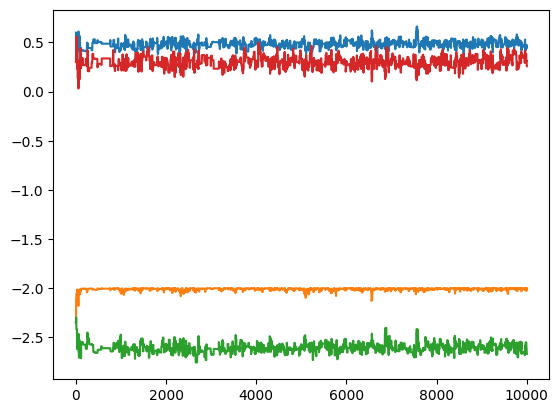

In [60]:
plt.plot(mh_samples)

In [ ]:
plt.hist(mh_samples,bins=100)
plt.show()

In [ ]:
# x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
# y_current = l(x_current)

#xtest = jnp.linspace(-5.0, 5.0, 1000).reshape(-1, 1)
xtest = jnp.linspace(-10.0, 10.0, 1000).reshape(-1, 1)

p_mean, p_std = evaluate_posterior(x_current, y_current, xtest,key, do_optimize=False, obs_stddev=obs_stddev)
plt.plot(xtest.squeeze(),p_mean, color='red')
plt.plot(xtest.squeeze(),l(xtest))
plt.plot(x_current, y_current, 'x', color='red')

plt.fill_between(
    xtest.squeeze(),
    p_mean - 2 * p_std,
    p_mean + 2 * p_std,
    alpha=0.5,
    label="Two sigma",
)
plt.xlim(-10,10)
plt.ylim(-150,10)

In [ ]:
plt.hist(errors)


In [ ]:
np.where(errors>0.8)

## Lotka Volterra

In [ ]:
from jax import vmap
from jax.experimental.ode import odeint

In [ ]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha = params
    beta=0.1
    delta=0.1
    gamma=1.5
    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
#@jit
def log_likelihood_lv(params):#, t, data, initial_conditions):
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets
    def integrate_single(params):
      params=jnp.exp(params)
      return integrate_model(params, t, initial_conditions)

    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)

    # Compute the error and log-likelihood for each parameter set
    errors = data - models
    #with disable_jit():
      #print(errors)
    sigma=1
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma**2)
    return log_likelihoods

# Example data
true_params = jnp.array(2.0)
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([1.0,1.1])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-358204.79520284 -435897.84280922]


In [ ]:
# define x current and y_current
params_current = jnp.array([3.0,-1.0])
true_params = jnp.array(2.0)
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current))
# set up empty mh_samples
params_current=params_current.reshape(-1,1)
y_current=y_current.reshape(-1,1)
N = 500
mh_samples=np.zeros((N))
mh_samples[0]=-1.0
# define max_ieter
max_iter= 10
#define test points
x_grid = jnp.arange(-2.5, 2.5, 0.01).reshape(-1, 1)
#x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)

test_points = jnp.arange(-2.5, 2.5, 0.1)
epsilon = 0.3
obs_stddev=1e-3
proposal='uniform'

In [ ]:
m=0
while m < max_iter:
  test_points= jnp.array([testpt for testpt in test_points if testpt not in params_current])
  test_point_utilities = loss_fast2(params_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev,True)



  i = jnp.argmin(jnp.array(test_point_utilities))
  x_new = test_points[i]
  #y_new = log_likelihood_lv(x_new)
  params_current = jnp.vstack([params_current, x_new])
  params_current = params_current.sort(axis=0)
  y_current =log_likelihood_lv(params_current).reshape(-1,1)


  m+=1

In [ ]:
params_current

In [ ]:
# x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
# y_current = l(x_current)

#xtest = jnp.linspace(-5.0, 5.0, 1000).reshape(-1, 1)
xtest = jnp.linspace(-1.0, 2.5, 100).reshape(-1, 1)

p_mean, p_std = evaluate_posterior(params_current, y_current, xtest,key, do_optimize=True, obs_stddev=obs_stddev)
plt.plot(xtest.squeeze(),p_mean, color='red')
plt.plot(xtest.squeeze(),log_likelihood_lv(xtest))
plt.plot(params_current, y_current, 'x', color='red')

plt.fill_between(
    xtest.squeeze(),
    p_mean - 2 * p_std,
    p_mean + 2 * p_std,
    alpha=0.5,
    label="Two sigma",
)
#plt.xlim(-10,10)
#plt.ylim(-150,10)

In [ ]:


D = gpx.Dataset(params_current, y_current)

posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
latent_dist = posterior.predict(mh_samples[0].reshape(-1,1), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)
m_now = predictive_dist.mean().reshape(-1,1)
v_now = predictive_dist.stddev().reshape(-1,1)
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    x_prop = (np.random.uniform() - 0.5)*0.5 + mh_samples[i-1]
  else:
    x_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  x_now = mh_samples[i-1]
  # find mean and variance at proposal and prev point
  #m,v = gpmh_eval_posterior(x_current,y_current,x_prop,x_now,key,obs_stddev)
  #m,v = gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev,D)
  m_prop,v_prop = gpmh_eval_posterior2(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev,D)
  m,v=get_it(posterior,params_current,x_prop,x_now,m_now,v_now,key,obs_stddev,D,m_prop,v_prop)
  C,C1,C2=get_cov(posterior,params_current,x_prop,x_now,m_now,v_now,key,obs_stddev,D,m_prop,v_prop)
  print('step',i,np.exp(log_epsilon_gamma(m,v,u)),np.exp(log_epsilon_gamma_pen(m,v,u)),jnp.exp(expected1(m,v)),'Current',x_now,'proposed',x_prop)
  print(m,v,u)
  print(v_prop**2,v_now**2,C,C1,C2)
  #errors[i-1,0]= jnp.exp(expected1(m,v))
  #errors[i-1]= np.exp(log_epsilon_gamma(m,v,u))
# here implement penalty
  qoi = m - v**2
  if qoi >= jnp.log(u):
    mh_samples[i] = x_prop
    m_now = m_prop
    v_now = v_prop
  else:
    mh_samples[i] = mh_samples[i-1]
  #qois[i-1]=qoi



## lotka volterra >=2d

In [ ]:
from jax import vmap
from jax.experimental.ode import odeint

In [ ]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha, beta, delta, gamma = params

    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
@jit
def log_likelihood_lv(log_params):#, t, data, initial_conditions):
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets
    params=jnp.exp(log_params)
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)

    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)

    # Compute the error and log-likelihood for each parameter set
    errors = data - models

    sigma=5000
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma) + 10.
    return log_likelihoods

# Example data
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([[1.0, 0.05,1.0,0.1], [2.0, 0.1,2.0,0.1],[1.1,1.1,1.1,1.1]])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-39.3908751  -40.88475172 -40.54467613]


In [ ]:
# This removes the terms that don't depend on x_new
def loss_fast2d(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    print(posterior.prior.kernel)

    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_std_new = predictive_dist.stddev()#.reshape(-1,1)

    latent_dist = posterior.predict(x_grid, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)
    p_std = predictive_dist.stddev().reshape(-1,1)
    p_mean = predictive_dist.mean().reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)
    print(np.shape(p_std_new),np.shape(p_std),np.shape(p_mean),np.shape(C))
    tau2 = C**2/(p_std_new.T**2 + obs_stddev**2)
    #print(np.shape(tau2))
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)
    #print(np.shape(log_loss))
    return(log_loss,np.mean(p_std),p_mean)

In [ ]:
# define x current and y_current
np.random.seed(10)
params_current =  jnp.array([[1.0, 0.05,1.0,0.1], [2.0, 0.1,2.0,0.1],[0.1,0.1,0.1,0.1],[-1.5,-1.5,-1.5,-1.5],[1.5,1.5,1.5,1.5]])
params_current = jnp.array(np.random.uniform([0,-3,-3,0],[1,-2,-2,1],(20,4)))
params_current=round(params_current,1)

true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))
# set up empty mh_samples
N = 500
mh_samples=np.zeros((N,4))
mh_samples[0,0]=0.0
mh_samples[0,1]=-1.0
mh_samples[0,2]=-1.0
mh_samples[0,3]=0.0
# define max_ieter
max_iter= 50
#define test points
'''
x1_range = jnp.arange(start = -2., stop = 2.1, step = 0.8)
x2_range = jnp.arange(start = -3., stop = 1.1, step = 0.8)
x3_range = jnp.arange(start = -3., stop = 1.1, step = 0.8)
x4_range = jnp.arange(start = -2., stop = 2.1, step = 0.8)
'''
x1_range = jnp.arange(start = -2., stop = 2.1, step = 0.4)
x2_range = jnp.arange(start = -3., stop = 1.1, step = 0.4)
x3_range = jnp.arange(start = -3., stop = 1.1, step = 0.4)
x4_range = jnp.arange(start = -2., stop = 2.1, step = 0.4)
x1_gridvalues,x2_gridvalues,x3_gridvalues,x4_gridvalues = jnp.meshgrid(x1_range, x2_range,x3_range,x4_range)

x_grid = jnp.vstack([x1_gridvalues.flatten(), x2_gridvalues.flatten(),x3_gridvalues.flatten(),x4_gridvalues.flatten()]).T

from scipy.stats import qmc
sampler = qmc.Sobol(d=4, scramble=False,seed=10)
x_grid = sampler.random_base2(m=10)
#x_grid=(x_grid-0.5)*2 + [1,-2,-2,1]
x_grid=x_grid + [0,-3,-3,0]

#x_grid=jnp.array(np.random.uniform([-2,-3,-3,-2],[2,1,1,2],(1000,4)))
#x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)

x1_range = jnp.arange(start = 0., stop = 1.1, step = 0.25)
x2_range = jnp.arange(start = -3., stop =-1.9, step = 0.25)
x3_range = jnp.arange(start = -3., stop =-1.9, step = 0.25)
x4_range = jnp.arange(start = 0., stop = 1.1, step = 0.25)
x1_gridvalues,x2_gridvalues,x3_gridvalues,x4_gridvalues = jnp.meshgrid(x1_range, x2_range,x3_range,x4_range)
test_points = jnp.vstack([x1_gridvalues.flatten(), x2_gridvalues.flatten(),x3_gridvalues.flatten(),x4_gridvalues.flatten()]).T

# here we generate testpoints uniformly in the box

test_points=round(jnp.array(np.random.uniform([0,-3,-3,0],[1,-2,-2,1],(1000,4))),1)
epsilon = 0.3
obs_stddev=1e-3
proposal='uniform'

In [ ]:
np.max(x_grid,axis=0)

array([ 0.99902344, -2.00097656, -2.00097656,  0.99902344])

In [ ]:
np.shape(params_current)

(20, 4)

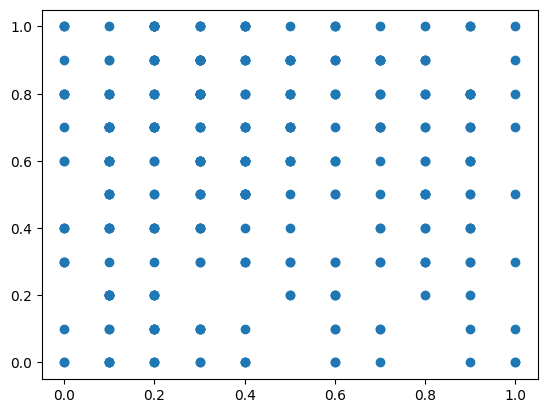

In [ ]:
plt.scatter(params_current[:,0],params_current[:,3])

In [ ]:
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))


In [ ]:
from sklearn.metrics import pairwise_distances
def remove_close_rows(arr1, arr2, threshold=1e-6):
    # Compute the distance between each pair of rows
    distances = pairwise_distances(arr1,arr2)
    #print(distances)

    # Check if any distance is below the threshold for each row in arr1
    is_close = jnp.any(distances < threshold, axis=1)

    # Keep rows that are not close to any row in arr2
    result = arr1[~is_close]

    return result

# Example usage
arr1 = jnp.array([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
arr2 = jnp.array([[1.0, 2.0], [7.0, 8.0]])

filtered_arr1 = remove_close_rows(arr1, arr2)
print(filtered_arr1)

[[3. 4.]
 [5. 6.]]


In [ ]:
y_current=jnp.array(log_likelihood_lv(params_current).reshape(-1,1))

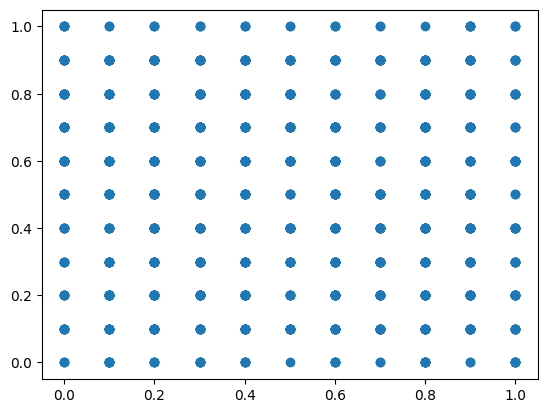

In [ ]:
plt.plot(test_points[:,3],test_points[:,0],'o')

(array([  1.,   0.,   0.,   6.,   8.,  25.,  27.,  46., 116.,  91.]),
 array([-355.62289578, -319.43306533, -283.24323489, -247.05340444,
        -210.86357399, -174.67374355, -138.4839131 , -102.29408265,
         -66.10425221,  -29.91442176,    6.27540869]),
 <BarContainer object of 10 artists>)

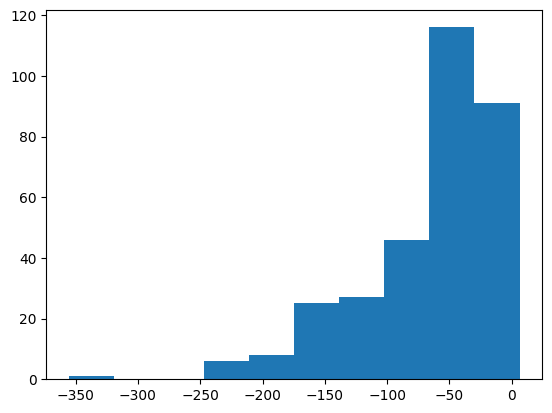

In [ ]:
plt.hist(y_current.reshape(1,-1),bins=10)

In [ ]:
np.shape(params_current)

(170, 4)

In [ ]:
np.random.seed(10)
m = 0
max_iter = 2
stds=np.zeros(max_iter)
while m < max_iter:
  #test_points= jnp.array([testpt for testpt in np.array(round(test_points,1)) if testpt not in np.array(params_current)])
  #test_points=jnp.array(remove_matching_rows(round(test_points,1),round(params_current,1)))
  #print(test_points)
  '''
  x1_range = jnp.array(np.random.uniform(-2,2,5))
  x2_range = jnp.array(np.random.uniform(-3,1,5))


  x1_gridvalues,x2_gridvalues,x3_gridvalues,x4_gridvalues = jnp.meshgrid(x1_range, x2_range,x2_range,x1_range)
  test_points = jnp.vstack([x1_gridvalues.flatten(), x2_gridvalues.flatten(),x3_gridvalues.flatten(),x4_gridvalues.flatten()]).T
  '''
  test_points=jnp.round(test_points,1)
  test_points = remove_close_rows(test_points,params_current)
  #print(test_points)
  test_point_utilities,std,pm = loss_fast2d(params_current, y_current, test_points, x_grid, key, obs_stddev)
  stds[m]=std


  i = jnp.argmin(jnp.array(test_point_utilities))
  x_new = test_points[i]
  print('Point',m,x_new)
  if m>=1:
    std_red=(stds[m]-stds[m-1])/stds[m-1]
    print(std_red)
    if np.abs(std_red) < 1e-6:
      break
  #y_new = log_likelihood_lv(x_new)
  params_current = jnp.vstack([params_current, x_new])
  #params_current = params_current.sort(axis=0)
  y_current =log_likelihood_lv(params_current).reshape(-1,1)


  m+=1





  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(0.23551511, dtype=float64), variance=Array(2.1938245, dtype=float64))


/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


(483,) (1024, 1) (1024, 1) (1024, 483)
Point 0 [ 0.8 -2.2 -2.2  0.3]


  0%|          | 0/1000 [00:00<?, ?it/s]

RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(0.235729, dtype=float64), variance=Array(2.19557872, dtype=float64))
(482,) (1024, 1) (1024, 1) (1024, 482)
Point 1 [ 0.1 -2.4 -2.4  0.5]
-0.006047695341889797


In [ ]:
np.shape(params_current)

(518, 4)

In [ ]:
params_current

Array([[ 0.8, -3. , -2.4,  0.7],
       [ 0.5, -2.8, -2.8,  0.8],
       [ 0.2, -2.9, -2.3,  1. ],
       [ 0. , -2.5, -2.2,  0.6],
       [ 0.7, -2.7, -2.1,  0.7],
       [ 0.5, -2.9, -2.6,  0.7],
       [ 0.4, -2.6, -2.4,  0.5],
       [ 0.7, -2.4, -2.2,  0.5],
       [ 0.9, -2.7, -2.9,  0.3],
       [ 0.1, -2.2, -3. ,  0.6],
       [ 0.5, -2.2, -2.8,  0.9],
       [ 0.4, -2.2, -2.7,  0.9],
       [ 0.3, -2.8, -2.6,  0.1],
       [ 0.8, -2.8, -2.6,  0.9],
       [ 1. , -2.5, -2.2,  0.3],
       [ 0.6, -2.1, -2.5,  0.6],
       [ 0. , -2.6, -2.9,  0.3],
       [ 0.3, -2.2, -3. ,  0.4],
       [ 0.3, -2.4, -2.7,  0. ],
       [ 0.9, -2.2, -2.1,  0.4],
       [ 1. , -2.8, -2.2,  0. ],
       [ 0.2, -2.1, -2. ,  1. ],
       [ 0. , -2.1, -2.3,  0. ],
       [ 0.1, -3. , -2.8,  0.7],
       [ 0.9, -2.1, -2.4,  0.1],
       [ 0.1, -2.8, -2.1,  0. ],
       [ 0.1, -2.1, -2.3,  0.5],
       [ 0.1, -2. , -2.7,  0.2],
       [ 0. , -3. , -2.9,  0.1],
       [ 0.1, -2.3, -2.8,  0. ],
       [ 0

In [ ]:
params_current[-15:,:]

Array([[ 0.5, -2.5, -2.1,  0.6],
       [ 0.3, -2.3, -2.1,  0.7],
       [ 0.2, -2. , -2.1,  0.3],
       [ 0. , -2.1, -2.1,  0.4],
       [ 0.4, -2.3, -2.1,  0.5],
       [ 0.4, -2. , -2.1,  0.2],
       [ 0.6, -2.2, -2.3,  0. ],
       [ 0.2, -2.7, -2.2,  0.9],
       [ 0.1, -2.7, -2.1,  1. ],
       [ 0.2, -2.8, -2.2,  0.7],
       [ 0.5, -2.5, -2.4,  0.8],
       [ 0.3, -2.9, -2.1,  0.5],
       [ 0.6, -2.4, -2.1,  0.5],
       [ 0.8, -2.2, -2.2,  0.3],
       [ 0.1, -2.4, -2.4,  0.5]], dtype=float64)

In [ ]:
#25/8 #2nd attempt
params_current=jnp.array(
    [[ 0.8, -3. , -2.4,  0.7],
       [ 0.5, -2.8, -2.8,  0.8],
       [ 0.2, -2.9, -2.3,  1. ],
       [ 0. , -2.5, -2.2,  0.6],
       [ 0.7, -2.7, -2.1,  0.7],
       [ 0.5, -2.9, -2.6,  0.7],
       [ 0.4, -2.6, -2.4,  0.5],
       [ 0.7, -2.4, -2.2,  0.5],
       [ 0.9, -2.7, -2.9,  0.3],
       [ 0.1, -2.2, -3. ,  0.6],
       [ 0.5, -2.2, -2.8,  0.9],
       [ 0.4, -2.2, -2.7,  0.9],
       [ 0.3, -2.8, -2.6,  0.1],
       [ 0.8, -2.8, -2.6,  0.9],
       [ 1. , -2.5, -2.2,  0.3],
       [ 0.6, -2.1, -2.5,  0.6],
       [ 0. , -2.6, -2.9,  0.3],
       [ 0.3, -2.2, -3. ,  0.4],
       [ 0.3, -2.4, -2.7,  0. ],
       [ 0.9, -2.2, -2.1,  0.4],
       [ 1. , -2.8, -2.2,  0. ],
       [ 0.2, -2.1, -2. ,  1. ],
       [ 0. , -2.1, -2.3,  0. ],
       [ 0.1, -3. , -2.8,  0.7],
       [ 0.9, -2.1, -2.4,  0.1],
       [ 0.1, -2.8, -2.1,  0. ],
       [ 0.1, -2.1, -2.3,  0.5],
       [ 0.1, -2. , -2.7,  0.2],
       [ 0. , -3. , -2.9,  0.1],
       [ 0.1, -2.3, -2.8,  0. ],
       [ 0.6, -2.1, -3. ,  0.2],
       [ 0. , -2.6, -2.1,  1. ],
       [ 0.1, -2.5, -2.4,  0.3],
       [ 0.1, -2.7, -2. ,  0.6],
       [ 0.9, -2.4, -2.2,  0.4],
       [ 0.5, -2.2, -2. ,  0.6],
       [ 0.7, -2. , -2. ,  0.1],
       [ 1. , -2.5, -2.2,  0.1],
       [ 0.4, -2.3, -2.2,  0.5],
       [ 0.7, -2.2, -2.4,  0. ],
       [ 0.4, -2. , -2.6,  0. ],
       [ 0.9, -2. , -2.1,  1. ],
       [ 0.9, -2.9, -2.1,  0.4],
       [ 0.5, -2.4, -2.1,  0.7],
       [ 0.6, -2.1, -2.3,  0.3],
       [ 0.6, -2.1, -2. ,  0.6],
       [ 0. , -2. , -2.1,  0.8],
       [ 0.6, -2.1, -2.6,  0. ],
       [ 0.6, -2.2, -2.4,  0. ],
       [ 0.1, -2.8, -2.2,  0.4],
       [ 0.8, -2.4, -2. ,  0.5],
       [ 0.2, -2.5, -2.6,  0.3],
       [ 0. , -2.5, -2.6,  0. ],
       [ 0.8, -2. , -2.1,  0.2],
       [ 0. , -2.4, -2. ,  0.4],
       [ 0. , -2.1, -2.6,  0.3],
       [ 0. , -2.9, -2. ,  0.7],
       [ 0.2, -2.5, -2.3,  0.4],
       [ 0.1, -2.5, -2.9,  0.1],
       [ 0.2, -2.2, -2.4,  0.5],
       [ 0.1, -2.1, -2.5,  0.8],
       [ 0.9, -2. , -2. ,  0.5],
       [ 1. , -2. , -2.2,  0. ],
       [ 0.1, -2.1, -2.6,  0.4],
       [ 0.2, -2. , -2.8,  0.2],
       [ 0.1, -2.1, -2.6,  0.5],
       [ 0.1, -2. , -2.7,  0.4],
       [ 0.1, -2. , -2.7,  0.5],
       [ 0.1, -2. , -2.7,  0.6],
       [ 0.2, -2.1, -2.8,  1. ],
       [ 0.5, -2. , -2.3,  0.9],
       [ 0.2, -2.3, -2.7,  0.1],
       [ 0.1, -2.4, -2.9,  0. ],
       [ 0.3, -2.3, -2.6,  0.3],
       [ 0.2, -2.1, -2.3,  0.2],
       [ 0.2, -2.1, -2.4,  0. ],
       [ 0.3, -2.2, -2.2,  0.4],
       [ 0.2, -2.1, -2.3,  0.1],
       [ 0.2, -2.1, -2. ,  0.1],
       [ 0.3, -2.1, -2.5,  0.1],
       [ 0.2, -2.3, -2.1,  0.2],
       [ 0.5, -2.1, -2.1,  1. ],
       [ 0.4, -2.4, -2.7,  0.5],
       [ 0.3, -2.2, -2.8,  0. ],
       [ 0.5, -2.2, -2.4,  0.4],
       [ 0.5, -2.4, -2.6,  0.7],
       [ 0.6, -2.5, -2.3,  0.8],
       [ 0.7, -2. , -2.2,  0.4],
       [ 0.4, -2.5, -2.4,  0.5],
       [ 0.2, -2.1, -2.3,  0. ],
       [ 0.5, -2.1, -2.4,  0.3],
       [ 0.1, -2.2, -2.6,  0.2],
       [ 0.1, -2. , -2.5,  0.2],
       [ 0.2, -2.3, -2.9,  0.1],
       [ 0.4, -2. , -2.1,  0. ],
       [ 0. , -2.5, -2.8,  0.6],
       [ 0.3, -2.2, -2.3,  0.1],
       [ 0.1, -2.2, -2.4,  0. ],
       [ 0.4, -2.3, -2.2,  0.3],
       [ 0.6, -2.2, -2.4,  0.2],
       [ 0.1, -2.4, -2.5,  1. ],
       [ 0.3, -2.1, -2.2,  1. ],
       [ 0.1, -2.1, -2.7,  0.2],
       [ 0.2, -2.2, -2.4,  0.1],
       [ 0.1, -2.5, -2.4,  0.2],
       [ 0.5, -2.1, -2.6,  0.2],
       [ 0.2, -2. , -3. ,  0. ],
       [ 0.3, -2.2, -3. ,  0.5],
       [ 0.3, -2. , -3. ,  0.1],
       [ 0.2, -2.1, -2.7,  0.8],
       [ 0.7, -2.2, -2.7,  0.3],
       [ 0.2, -2.1, -2.6,  0.7],
       [ 0.1, -2.2, -2.5,  0.9],
       [ 0.1, -2.1, -3. ,  0.1],
       [ 0.6, -2.5, -2.1,  1. ],
       [ 0.3, -2.1, -2.4,  0.4],
       [ 0.3, -2.3, -2.5,  0.7],
       [ 0.8, -2.3, -2.7,  0.4],
       [ 0.9, -2.4, -2.9,  0.7],
       [ 0.9, -2.4, -2.5,  0.3],
     [ 1. , -2.6, -2.7,  0.5],
       [ 0.8, -2.4, -2.8,  0.3],
       [ 0.9, -2.1, -2.6,  0.6],
       [ 0.6, -2.2, -2.7,  0.5],
       [ 0.9, -2.5, -2.6,  0.6],
       [ 0.4, -2.2, -2.7,  0.5],
       [ 0.8, -2.3, -2.9,  0.7],
       [ 0.7, -2.3, -2.8,  0.8],
       [ 0.7, -2.2, -3. ,  0.7],
       [ 0.8, -2.3, -2.5,  0.4],
       [ 0.9, -2.4, -2.8,  0.6],
       [ 0.7, -2.6, -2.6,  0.4],
       [ 0.6, -2.1, -2.9,  0.5],
       [ 0.8, -2.4, -2.6,  0.3],
       [ 0.9, -2.1, -2.5,  0.5],
       [ 0.5, -2.3, -3. ,  0.3],
       [ 0.4, -2.5, -2.7,  0.1],
       [ 0.6, -2.8, -2.9,  0.2],
       [ 0.8, -2. , -2.3,  0.5],
       [ 0.5, -2.5, -3. ,  0.6],
       [ 0.4, -2.5, -2.9,  0. ],
       [ 0.6, -2.2, -2.6,  0.1],
       [ 0.9, -2.6, -2.5,  0.2],
       [ 0. , -2.1, -2.6,  0.8],
       [ 0.2, -2. , -2.7,  0.8],
       [ 0.3, -2.1, -2.7,  0.9],
       [ 0.5, -2. , -2.2,  0.9],
       [ 0.3, -2.1, -2.8,  0.8],
       [ 0.1, -2.2, -2.9,  0.7],
       [ 0.4, -2.2, -2.5,  1. ],
       [ 0.3, -2.3, -2.4,  0.8],
       [ 0.3, -2.2, -2.1,  0.9],
       [ 0.9, -2.9, -2.8,  0. ],
       [ 0.8, -2. , -2.3,  0.6],
       [ 0.6, -2.1, -2.7,  1. ],
       [ 0.7, -2.1, -2.4,  0.9],
       [ 0.7, -3. , -2.9,  0.9],
       [ 0.7, -2.3, -2. ,  0.7],
       [ 0.2, -2.5, -2.2,  0.8],
       [ 0.3, -2.3, -2.2,  0.9],
       [ 0.4, -2. , -2.2,  0.8],
       [ 0.4, -2.2, -2.7,  1. ],
       [ 0.2, -2.6, -2.1,  0.7],
       [ 0.5, -2.4, -2.8,  0.9],
       [ 0.8, -2.2, -2.4,  0.8],
       [ 0.5, -2.4, -2.5,  0.9],
       [ 0.1, -2.1, -2.7,  0.6],
       [ 0.1, -2. , -2.1,  0.9],
       [ 0.4, -2.1, -2.1,  1. ],
       [ 0.2, -2. , -2. ,  0.6],
     [ 0.2, -2.4, -2.1,  1. ],
       [ 0.3, -2.9, -2.1,  1. ],
       [ 0.3, -2. , -2.8,  0.9],
       [ 0.3, -2. , -2.4,  0.7],
       [ 0.3, -2.1, -3. ,  0.6],
       [ 0.8, -2.2, -2.9,  0.8],
       [ 0.2, -2.2, -2.9,  0.7],
       [ 0. , -2.1, -2.8,  0.9],
       [ 0.5, -2.2, -2.7,  0.6],
       [ 0.4, -2.1, -2.3,  0.6],
       [ 0.4, -2.4, -2.9,  0.7],
       [ 0.6, -2.5, -2.8,  0.9],
       [ 0.4, -2.7, -2.6,  1. ],
       [ 0.4, -2.8, -2.9,  0.5],
       [ 0.2, -2.4, -2.5,  1. ],
       [ 0.1, -2.3, -2.7,  0.7],
       [ 0.2, -2.1, -2.9,  0.9],
       [ 0.8, -2.1, -3. ,  0.3],
       [ 0.3, -2.4, -2.3,  0.8],
       [ 0.2, -2.2, -2.8,  0.4],
       [ 0.3, -2.3, -2.9,  0.5],
       [ 0. , -2.3, -3. ,  0.4],
       [ 0.8, -2.1, -2. ,  0.5],
       [ 0.9, -2.3, -2.5,  0.7],
       [ 0.6, -2.2, -2.4,  0.9],
       [ 0.5, -2.2, -2.5,  0.8],
       [ 0.3, -2.5, -2.3,  0.8],
       [ 0.3, -2.4, -2.2,  0.6],
       [ 0.4, -2.6, -2.5,  0.9],
       [ 0.5, -2.2, -2.9,  0.8],
       [ 0.7, -2.5, -2.7,  0.9],
       [ 0.9, -2.1, -2.6,  0.8],
       [ 0.6, -2.4, -2.2,  0.6],
       [ 0.2, -2.6, -2.3,  1. ],
       [ 0.3, -2.3, -2.6,  0.8],
       [ 0.4, -2.3, -2.6,  0.6],
       [ 0.7, -2.1, -2.4,  0.8],
       [ 0.8, -2.1, -2.4,  1. ],
       [ 0.5, -2.3, -2.8,  0.7],
       [ 0.6, -2.7, -2.2,  0.3],
       [ 0.9, -2.3, -2.4,  0.8],
       [ 0.3, -2.4, -3. ,  0.5],
       [ 0.4, -2.1, -2.5,  0.6],
       [ 0.4, -2.5, -2.1,  0.8],
       [ 1. , -2.4, -2.5,  0.9],
       [ 0.4, -2.4, -2. ,  0.4],
       [ 0.5, -2.1, -2.2,  0.8],
       [ 0.7, -2.8, -2.8,  0.9],
       [ 0.8, -2.2, -2.6,  0.9],
       [ 0.8, -2.3, -2.4,  0.9],
     [ 0.6, -2.2, -2.7,  0.9],
       [ 0.3, -2.2, -2.8,  0.7],
       [ 1. , -2.3, -2.3,  0.7],
       [ 0.3, -2.2, -2.5,  1. ],
       [ 1. , -2.2, -2.5,  1. ],
       [ 0.9, -2. , -2.3,  0.6],
       [ 0. , -2.3, -2.8,  1. ],
       [ 0.4, -2.6, -2.9,  0.3],
       [ 0.9, -2.2, -2.1,  0.8],
       [ 0.7, -2.4, -2.5,  1. ],
       [ 0.3, -2.6, -2.4,  0.4],
       [ 0.9, -2.3, -2.2,  1. ],
       [ 0.4, -2.2, -2.3,  0.6],
       [ 0.1, -2.4, -2.7,  0.7],
       [ 0.1, -2.6, -2.8,  0.7],
       [ 0.1, -2.5, -2.6,  0.7],
       [ 0.8, -2.3, -3. ,  0.6],
       [ 0.5, -2.6, -2.2,  0.9],
       [ 0.2, -2.4, -2.8,  0.9],
       [ 0.2, -2.5, -2.9,  0.9],
       [ 0.1, -2.9, -2.8,  0.7],
       [ 0.3, -2.8, -3. ,  0.9],
       [ 0. , -2.2, -2.4,  0.8],
       [ 0.2, -2.3, -2.3,  0.9],
       [ 0.3, -2.4, -2.1,  0.9],
       [ 0.3, -2.4, -2.9,  0.8],
       [ 0.3, -2.6, -2.7,  0.9],
       [ 0.3, -2.5, -2.6,  0.9],
       [ 0.3, -2.6, -2.9,  0.8],
       [ 0.3, -2.5, -2.7,  0.9],
       [ 0.1, -2.2, -2.5,  0.8],
       [ 0.3, -2.4, -2.9,  1. ],
       [ 0. , -2.7, -2.3,  1. ],
       [ 0.5, -2.3, -2.6,  0.7],
       [ 0.7, -2.3, -2.5,  0.3],
       [ 0.9, -2.6, -2.6,  0.8],
       [ 0.9, -2.5, -2.3,  0.8],
       [ 0.8, -2.5, -2.3,  0.8],
       [ 0.6, -2.4, -2.8,  1. ],
       [ 0.3, -2.2, -2.9,  0.3],
       [ 0.2, -2.3, -2.8,  0.4],
       [ 0.4, -2.8, -3. ,  0.6],
       [ 0.2, -2.8, -2.3,  0.9],
       [ 0.7, -2.5, -2.9,  0.9],
       [ 0.6, -2.4, -3. ,  0.8],
       [ 0.9, -2.3, -2.7,  0.7],
       [ 0.2, -2.7, -2.3,  1. ],
       [ 0.4, -2.6, -2.7,  0.5],
       [ 0.2, -2. , -2.9,  0.5],
       [ 0.2, -2.6, -2.7,  1. ],
     [ 0.7, -2.1, -2.5,  0.7],
       [ 0.7, -2. , -2.8,  0.8],
       [ 0.5, -2.1, -2.5,  0.5],
       [ 0.9, -2.4, -2.3,  1. ],
       [ 0.4, -2.5, -2.9,  0.9],
       [ 0.6, -2.4, -2. ,  0.1],
       [ 0.1, -2.7, -2.9,  0.7],
       [ 0.3, -2.4, -2.8,  0.6],
       [ 0.4, -2.8, -2.9,  0.7],
       [ 0.4, -2.6, -2.7,  1. ],
       [ 0.1, -2.8, -2.4,  0.6],
       [ 0.3, -2.4, -2.8,  0.8],
       [ 0.3, -2.4, -3. ,  0.6],
       [ 0.1, -2.7, -2.6,  0.8],
       [ 0.4, -2.4, -2.7,  0.3],
       [ 0.2, -2.9, -2.3,  0.8],
       [ 0.4, -2.6, -2.2,  0.7],
       [ 0.3, -3. , -2. ,  0.6],
       [ 0.1, -2.1, -2.2,  0.5],
       [ 0.5, -2.1, -3. ,  0.2],
       [ 0.8, -2. , -2.8,  0.5],
       [ 0.5, -2.9, -3. ,  0.6],
       [ 0.2, -2.1, -3. ,  0.2],
       [ 0.1, -2.6, -2.3,  0.4],
       [ 0.7, -2.3, -2.6,  0.1],
       [ 0. , -2.4, -2.3,  0.8],
       [ 0.4, -2.5, -2.3,  0.9],
       [ 0.2, -2.1, -2.3,  0.7],
       [ 0. , -2.2, -2.3,  0.4],
       [ 0.3, -2.1, -2.2,  0.9],
       [ 0.4, -2.5, -2.3,  0.8],
       [ 0.4, -2.6, -2.1,  0.6],
       [ 0.4, -2.7, -2.2,  0.7],
       [ 0.6, -2.3, -2.4,  0.8],
       [ 0.3, -2.3, -2.6,  0.5],
       [ 0.1, -3. , -2.4,  0.2],
       [ 0. , -2.3, -2.9,  0.3],
       [ 0.3, -2.4, -2.1,  0.6],
       [ 0.3, -2.4, -2.1,  0.7],
       [ 0.2, -2.2, -2.3,  0.7],
       [ 0.1, -2.9, -2.2,  0.8],
       [ 0.1, -2.4, -2.2,  0.6],
       [ 0.2, -2.4, -3. ,  0.4],
       [ 0.9, -2.2, -2.8,  0.8],
       [ 1. , -2.2, -2.8,  0.8],
       [ 0.6, -2. , -2.5,  0.7],
       [ 0.7, -2.1, -2.4,  0.6],
       [ 0.3, -2.2, -2.5,  0.6],
       [ 0.2, -2.2, -2.4,  0.7],
       [ 0.2, -2.5, -2.4,  0.6],
     [ 0.8, -2.4, -2.5,  0.9],
       [ 0.8, -2.6, -2.7,  0.9],
       [ 0.7, -2.9, -2.8,  0.8],
       [ 0.8, -2.3, -2.6,  0.9],
       [ 0.7, -2.6, -2.4,  0.9],
       [ 0.5, -2.7, -2. ,  0.8],
       [ 0.1, -2.6, -2.1,  0.9],
       [ 0.1, -2.5, -2.1,  0.9],
       [ 0. , -2.5, -2. ,  0.6],
       [ 0.1, -2.2, -2. ,  0.8],
       [ 0. , -2.3, -2.1,  0.8],
       [ 0.1, -2.3, -2.3,  0.8],
       [ 0.7, -2.3, -2.2,  0.3],
       [ 0.8, -2.2, -2. ,  0.4],
       [ 0.9, -2.4, -2.3,  0.3],
       [ 0.3, -2.1, -2.2,  0.4],
       [ 0.4, -2. , -2. ,  0.4],
       [ 0.6, -2.2, -2.8,  0.7],
       [ 0.6, -2.5, -2.7,  0.6],
       [ 0.1, -3. , -2.4,  0.6],
       [ 0.8, -2.6, -3. ,  0.9],
       [ 0.8, -2.9, -2.8,  0.8],
       [ 0.6, -2. , -2.1,  0.6],
       [ 0.5, -2.1, -3. ,  0.7],
       [ 0.9, -2.4, -2.6,  0.7],
     [ 0.8, -2.4, -2.6,  0.8],
       [ 1. , -2.3, -2.7,  1. ],
       [ 0.4, -2.1, -2.6,  0.3],
       [ 0.8, -2.6, -2.6,  0.7],
       [ 0.3, -2.7, -2.6,  0.3],
       [ 0.3, -2.1, -2.6,  0.7],
       [ 0.2, -2. , -2.6,  0.5],
       [ 0.7, -2. , -2.6,  0.3],
       [ 0.9, -2. , -2.6,  0.3],
       [ 0.7, -2. , -2.9,  0.5],
       [ 0.6, -2.6, -2.6,  0.5],
       [ 0.4, -2.5, -2.8,  0.8],
       [ 0.5, -2.4, -2.7,  0.9],
       [ 0.1, -2.8, -2.9,  0.7],
       [ 0.1, -2.4, -3. ,  0.6],
       [ 0.1, -2.2, -3. ,  0.3],
       [ 0.3, -2.4, -2.9,  0.7],
       [ 0.2, -2.3, -2.1,  0.9],
       [ 0.4, -2.3, -2. ,  0.8],
       [ 0.3, -2.4, -2.4,  0.9],
       [ 0.4, -2.6, -2.6,  1. ],
       [ 0.1, -2.9, -2.6,  0.8],
       [ 0.3, -2.1, -2.5,  0.7],
       [ 0.2, -2.9, -2.4,  0.9],
       [ 0. , -2.2, -2.9,  0.9],
     [ 0.2, -2.6, -2.7,  0.8],
       [ 0.5, -2.5, -2.9,  0.9],
       [ 0.2, -2.3, -2.2,  0.3],
       [ 0.4, -2.5, -2.6,  0.9],
       [ 0.7, -2.3, -2.6,  0.9],
       [ 0.2, -2.7, -2.7,  0.8],
       [ 0.5, -2.6, -2.5,  0.9],
       [ 0.3, -2.8, -2.8,  0.8],
       [ 0.3, -2.7, -2.6,  0.6],
       [ 0.2, -2.5, -2.7,  0.8],
       [ 0.6, -2.8, -2.5,  0.8],
       [ 0.6, -2.5, -2.5,  0.3],
       [ 0.7, -2.4, -2.4,  0.7],
       [ 0.7, -2.5, -2.4,  0.6],
       [ 0.7, -2.6, -2.3,  0.6],
       [ 0.4, -2.5, -2.4,  0.8],
       [ 0.5, -2.9, -2.4,  0.8],
       [ 0.7, -2.4, -2. ,  0.8],
       [ 0.2, -2.7, -2.6,  0.6],
       [ 0.3, -3. , -2.9,  0.8],
     [ 0.7, -2.9, -2.5,  0.7],
       [ 0.5, -2.7, -2.1,  0.9],
       [ 0.4, -2.6, -2.1,  0.9],
       [ 0.7, -2.9, -2.1,  0.8],
       [ 0.5, -2.5, -2.7,  0.2],
       [ 0.5, -2.1, -2.3,  0.3],
       [ 0.5, -2.1, -2.5,  0.2],
       [ 0.2, -2.2, -2.5,  0.4],
       [ 0.4, -2.8, -2.8,  0.7],
       [ 0.6, -2.6, -2.6,  0.8],
       [ 0.5, -2.1, -2.7,  0.2],
       [ 1. , -2.2, -2.1,  0.6],
       [ 0.9, -2.2, -2. ,  0.6],
       [ 0.2, -2.4, -3. ,  0.9],
       [ 0.8, -2. , -2.5,  0.8],
     [ 0.8, -2.1, -2.4,  0.3],
       [ 0.2, -2.2, -2.2,  0.2],
       [ 0. , -2.4, -2.6,  0.4],
       [ 0.5, -2.8, -2.1,  0.4],
       [ 0.5, -2.9, -2.1,  0.2],
       [ 0.4, -2.7, -2.2,  0.8],
       [ 0.6, -2.8, -2.1,  0.8],
       [ 1. , -2.6, -2. ,  0.7],
       [ 0.4, -2.5, -2.2,  0.8],
       [ 0.1, -3. , -2.2,  0.9],
       [ 0.5, -2.1, -2.9,  0.1],
       [ 0.8, -2.4, -2.9,  0.3],
       [ 0.3, -2.5, -2.7,  0.6],
       [ 0.1, -2.5, -2.8,  0.8],
       [ 0.9, -2. , -2.1,  0.4],
     [ 0.4, -2.4, -2.6,  0.6],
       [ 0.3, -2.7, -2.5,  0.6],
       [ 0. , -2.7, -2.3,  0.8],
       [ 0.2, -2.9, -2.8,  0.6],
       [ 0.5, -2.7, -2.6,  0.4],
       [ 0.5, -2.2, -2.8,  0.5],
       [ 0.5, -2.2, -2.9,  0.4],
       [ 0.5, -2.3, -3. ,  0.1],
       [ 0.5, -2.7, -2.6,  0.2],
       [ 0.4, -3. , -2.8,  0.4],
       [ 0. , -2.2, -2.5,  0.2],
       [ 0.5, -2.7, -2.7,  0.7],
       [ 0.6, -2.7, -2.4,  1. ],
       [ 0.6, -2.5, -2.8,  0.8],
       [ 0.1, -2.9, -2.8,  0.4],
       [ 0.7, -2.6, -2.8,  0.8],
       [ 0.8, -2.6, -2.8,  0.8],
       [ 0.4, -2.9, -2.9,  0.8],
       [ 0.7, -2.6, -2.8,  0.6],
       [ 0.3, -2.5, -2.7,  0.7],
     [ 0.2, -2.4, -2.7,  0.7],
       [ 0.8, -2.4, -2.3,  0.7],
       [ 0.9, -2.3, -2.3,  0.5],
       [ 0.8, -2.4, -2.2,  0.8],
       [ 0.9, -2.6, -2.3,  0.6],
       [ 0.9, -2.2, -2. ,  0.3],
       [ 0.7, -2.8, -2.2,  0.6],
       [ 0.9, -2.7, -2.9,  1. ],
       [ 0.8, -2.2, -2.1,  0.5],
       [ 0.9, -2.6, -3. ,  0.7],
       [ 0.6, -2.2, -2.4,  0.6],
       [ 0.7, -2.5, -2.4,  0.5],
       [ 0.5, -2.6, -2.4,  0.8],
       [ 0.7, -2.5, -2.3,  0.7],
       [ 0.9, -2.4, -2.4,  0.4],
     [ 0.7, -2.7, -2.2,  1. ],
       [ 0.7, -2.4, -2.8,  0.8],
       [ 0.5, -2.8, -2.7,  0.7],
       [ 0.4, -2.8, -2.5,  0.5],
       [ 0.2, -2.2, -2.5,  0.6],
       [ 0.6, -2.4, -3. ,  0.3],
       [ 0.8, -2.9, -2.1,  0.5],
       [ 0.8, -2.8, -2.1,  1. ],
       [ 0.3, -2.7, -2.8,  0.7],
       [ 0.5, -2.6, -2.6,  0.8],
       [ 0.5, -2.1, -2.2,  0.2],
       [ 0.5, -2.2, -2.3,  0.6],
       [ 0.2, -2.4, -2.3,  0.3],
       [ 0.4, -2.2, -2.2,  0.5],
       [ 0. , -2.4, -2.5,  0.6],
     [ 0.2, -2.6, -2.1,  0.9],
       [ 0. , -2.7, -2.2,  0.7],
       [ 0.5, -2.8, -2.4,  0. ],
       [ 0.5, -2.4, -2.4,  0.4],
       [ 0.3, -2.4, -2.3,  0.5],
       [ 0.3, -2.1, -2.1,  0.3],
       [ 0.2, -2.1, -2.5,  0.4],
       [ 0.9, -2.4, -2.1,  0.9],
       [ 0.3, -3. , -3. ,  0.5],
       [ 0.7, -2.8, -2.9,  0.6],
       [ 0.5, -2.6, -2.5,  1. ],
       [ 0.6, -2.7, -2.7,  1. ],
       [ 0.7, -2.5, -2.8,  0.8],
       [ 0.6, -2.7, -2.6,  0.9],
       [ 0.4, -2.8, -2.4,  0.9],
       [ 0.3, -2.9, -2.6,  0.7],
       [ 0.2, -2.8, -2.6,  0.7],
       [ 0.2, -2.3, -2.1,  0.4],
       [ 0.9, -2.7, -2.3,  0.4],
       [ 0.2, -2.2, -2.2,  0.6],
     [ 0.5, -2.9, -2.2,  0.7],
       [ 0.5, -2.9, -2.1,  0.3],
       [ 0.6, -2.9, -2. ,  0.7],
       [ 0.3, -2.9, -2.3,  0.9],
       [ 0.2, -2.9, -2.5,  0.8],
       [ 0.2, -3. , -2.6,  0.8],
       [ 0.4, -2.8, -2.1,  0.5],
       [ 0.5, -2.9, -2.7,  0.7],
       [ 0.6, -3. , -2.2,  1. ],
       [ 0.2, -2.2, -2.1,  0.6],
       [ 0.1, -2.2, -2.3,  0.7],
       [ 0.1, -2.1, -2.1,  0.6],
       [ 0.3, -2.1, -2.5,  0.4],
       [ 0.2, -2.2, -2. ,  0.4],
       [ 0.3, -2.5, -2.1,  0.7],
  [ 0.5, -2.5, -2.1,  0.6],
  [ 0.3, -2.3, -2.1,  0.7],
  [ 0.2, -2. , -2.1,  0.3],
  [ 0. , -2.1, -2.1,  0.4],
  [ 0.4, -2.3, -2.1,  0.5],
  [ 0.4, -2. , -2.1,  0.2],
  [ 0.6, -2.2, -2.3,  0. ],
  [ 0.2, -2.7, -2.2,  0.9],
  [ 0.1, -2.7, -2.1,  1. ],
  [ 0.2, -2.8, -2.2,  0.7],
  [ 0.5, -2.5, -2.4,  0.8],
  [ 0.3, -2.9, -2.1,  0.5],
  [ 0.6, -2.4, -2.1,  0.5],
     [ 0.8, -2.2, -2.2,  0.3],
       [ 0.1, -2.4, -2.4,  0.5]]
    )

In [ ]:
def is_point_in_box(point, min_corner, max_corner):
    """
    Check if a point is inside an axis-aligned box.

    Parameters:
    point (array-like): Coordinates of the point (e.g., [x, y, z]).
    min_corner (array-like): Coordinates of the minimum corner of the box.
    max_corner (array-like): Coordinates of the maximum corner of the box.

    Returns:
    bool: True if the point is inside the box, False otherwise.
    """
    # Convert inputs to numpy arrays for element-wise operations

    min_corner = jnp.array(min_corner)
    max_corner = jnp.array(max_corner)

    # Check if the point is within the bounds
    return jnp.all(point >= min_corner) and jnp.all(point <= max_corner)

# Example usage with arrays:
point = jnp.array([7,3,4])
min_corner = jnp.array([1, 2, 3])
max_corner = jnp.array([5, 6, 7])

if is_point_in_box(point, min_corner, max_corner):
    print("The point is inside the box.")
else:
    print("The point is outside the box.")

The point is outside the box.


In [ ]:
def gpmh_eval_posterior_wp(posterior,x_current,x_prop,x_now,key,obs_stddev, D ,min,max):
  x_eval = jnp.vstack((x_now,x_prop))
  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[1]]), posterior)
  #x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)
  if not is_point_in_box(x_prop,min,max):
    mean= -(1e+5)

  else:
    m = predictive_dist.mean().reshape(-1,1)
    mean= m[1]-m[0]


  return mean,v[0]**2 + v[1]**2 - 2*C-2*posterior.likelihood.obs_stddev**2

In [ ]:
def gpmh_eval_posterior_2d(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  #x_eval = x_eval
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(jnp.array([x_eval[1]]), train_data=D)

  predictive_dist = posterior.likelihood(latent_dist)

  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  #C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval,v)
  return m,v

In [ ]:
def get_it_2d(posterior,x_current,x_prop,x_now,m_now,v_now,key,obs_stddev, D,m,v):
  x_eval = jnp.vstack([x_now,x_prop])

  #x_eval = x_eval.reshape(-1,1)
  C = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[1]]), posterior)
  #C1 = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[0]]), posterior)
  #C2 = two_point_covariance(x_current, jnp.array([x_eval[1]]), jnp.array([x_eval[1]]), posterior)
  #print(C,C1,C2,v_now**2-posterior.likelihood.obs_stddev**2,v**2-posterior.likelihood.obs_stddev**2)
  #print(m,x_eval)
  return m-m_now,v**2 + v_now**2 - 2*C-2*posterior.likelihood.obs_stddev**2

In [ ]:
def gpmh_eval_posterior_2d_new(posterior,x_current,x_prop,x_now,key,obs_stddev, D):
  x_eval = jnp.vstack((x_now,x_prop))

  #x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
  #print( x_eval[0], x_eval[1],x_current)
  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[1]]), posterior)
  #C1 = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[0]]), posterior)
  #C2= two_point_covariance(x_current, jnp.array([x_eval[1]]), jnp.array([x_eval[1]]), posterior)
  #print(v**2,C,C1,C2,posterior.likelihood.obs_stddev**2)
  #print(m,x_eval)
  return m[1]-m[0],v[0]**2 + v[1]**2 - 2*C-2*posterior.likelihood.obs_stddev**2

In [ ]:
test_points=round(jnp.array(np.random.uniform([0,-3,-3,0],[1,-2,-2,1],(1000,4))),1)

In [ ]:
params_current=test_points[:600,:]
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))

In [ ]:
params_current_full=params_current

In [61]:
params_current=params_current_full[:200,:]
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))

In [62]:
D = gpx.Dataset(params_current, y_current)

posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [63]:
np.shape(params_current)

(200, 4)

In [64]:
import pandas as pd
df= pd.DataFrame(params_current)

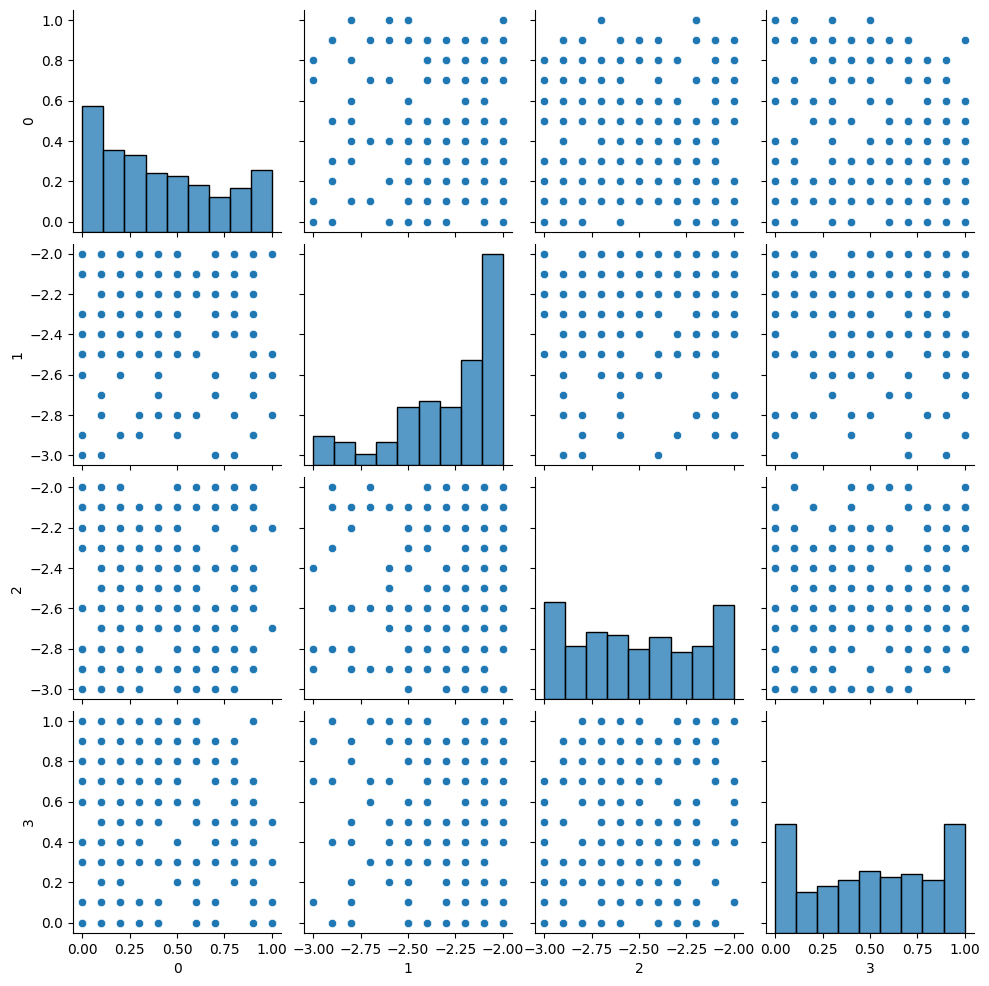

In [65]:
import seaborn as sns
sns.pairplot(df)

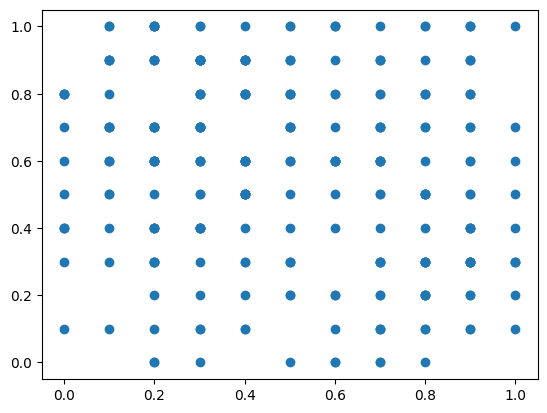

In [ ]:
plt.scatter(params_current[:,0],params_current[:,3])

In [ ]:
mini = jnp.array([0,-3,-3,0])
maxi=jnp.array([1.5,-1.5,-1.5,1.5])

In [ ]:
posterior.likelihood.obs_stddev

Array(0.00100692, dtype=float64)

In [67]:
np.random.seed(10)
N = 10000
mh_samples=np.zeros((N,4))
mh_samples[0,0]=0.6#0.6#0.25
mh_samples[0,1]=-2.35#-2.35#-0.75
mh_samples[0,2]=-2.35#-2.35#-0.75
mh_samples[0,3]=0.3#0.3#0.1
q_means=np.zeros((N,4))
q_means[0] = mh_samples[0]
q_cov = np.eye(4)*0.1#0.01#[0.05,0.01,0.01,0.05]
t_0 = 10#20
proposal='normal'
min = jnp.array([0,-3,-3,0])
max= jnp.array([1,-2,-2,1])

#latent_dist = posterior.predict(jnp.array([mh_samples[0]]), train_data=D)
#predictive_dist = posterior.likelihood(latent_dist)
#m_now = predictive_dist.mean()
#v_now = predictive_dist.stddev()
for i in range(1,N):
  # centred around prev step with var 1
  if i > t_0:
    q_cov=((i-2)/(i-1))*q_cov + ((2.4**2)/(4*(i-1)))*((i-1)*(np.outer(q_means[i-2],q_means[i-2]))-i*np.outer(q_means[i-1],q_means[i-1])+np.outer(mh_samples[i-1],mh_samples[i-1])+ 1e-6*np.eye(4))
  if proposal == 'uniform':
    x_prop =  mh_samples[i-1]+(np.random.uniform(0,1,4) - 0.5)*[0.1,0.01,0.01,0.1] #[0.1,0.1,0.1,0.1] * 4. #[0.1,0.01,0.01,0.1]
  else:
   x_prop=np.random.multivariate_normal(mh_samples[i-1],q_cov)
  u = np.random.uniform()
  x_now = mh_samples[i-1]
  # find mean and variance at proposal and prev point
  #m,v = gpmh_eval_posterior_2d_new(posterior,params_current,x_prop,x_now,key,obs_stddev,D)
  m,v = gpmh_eval_posterior_wp(posterior,params_current,x_prop,x_now,key,obs_stddev,D,min,max)
  print('step',i,np.exp(log_epsilon_gamma(m,v,u)),np.exp(log_epsilon_gamma_pen(m,v,u)),jnp.exp(expected1(m,v)))
  print('Current',x_now,'proposed',x_prop)

  #print(m,v,jnp.log(u))
  #errors[i-1,0]= jnp.exp(expected1(m,v))
  #errors[i-1]= np.exp(log_epsilon_gamma(m,v,u))

  # here implement penalty
  # sample from normal with this mean and variance
  #qoi = np.mean(np.random.normal(0,1,100))*np.sqrt(v)+m - 0.5*v/100
  #qoi= m-0.5*v
  qoi = np.random.normal(0,1,1)*np.sqrt(v)+m - 0.5*v
  print(qoi,m,v,jnp.log(u))
  if qoi>=jnp.log(u):#qoi >= jnp.log(u):
    mh_samples[i] = x_prop
    #m_now = m_prop
    #v_now = v_prop
  else:
    mh_samples[i] = mh_samples[i-1]
  #qois[i-1]=qoi
  q_means[i] = q_means[i-1] + (mh_samples[i]-q_means[i-1])/(i+1)



Streaming output truncated to the last 5000 lines.
Current [ 0.27987529 -2.1379329  -2.19251572  0.67184845] proposed [ 0.30272774 -2.19542378 -2.22867952  0.62241688]
[[-10.93353602]] [-10.95284332] [[0.00168463]] -1.1975420979683475
step 8334 [[0.00017021]] [[0.84798261]] 1.3085678748096505
Current [ 0.27987529 -2.1379329  -2.19251572  0.67184845] proposed [ 0.50536305 -2.1280813  -2.16549673  0.72156714]
[[-0.44202506]] [-0.42906015] [[0.02067928]] -0.576863584890081
step 8335 [[4.42682729e-130]] [[0.]] 0.5578324692661352
Current [ 0.50536305 -2.1280813  -2.16549673  0.72156714] proposed [ 0.53346672 -2.11512371 -2.19565158  0.66453808]
[[-3.28042488]] [-3.30344368] [[0.00183611]] -1.1801475046850134
step 8336 [[0.]] [[0.]] 0.003979487763565255
Current [ 0.50536305 -2.1280813  -2.16549673  0.72156714] proposed [ 0.59058651 -2.12811868 -2.1404428   0.76863347]
[[1.84819935]] [1.84537128] [[0.00385606]] -2.689754547776801
step 8337 [[4.32605633e-14]] [[0.]] 0.6188423113673158
Current 

In [ ]:
q_cov

array([[ 2.04161538e-03, -2.15540379e-05,  2.53302189e-04,
        -1.04841739e-03],
       [-2.15540379e-05,  3.19683085e-04, -1.69836089e-04,
         1.42794653e-04],
       [ 2.53302189e-04, -1.69836089e-04,  3.20452281e-03,
        -5.20609402e-04],
       [-1.04841739e-03,  1.42794653e-04, -5.20609402e-04,
         4.60293978e-03]])

In [ ]:
#save mh samples for plotting
np.savetxt('5-13-26-aug.txt', mh_samples, delimiter=',')

In [ ]:
samples = np.loadtxt("5-13-26-aug.txt", comments="#", delimiter=",", unpack=False)

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   3.,
          4.,  10.,  42.,  98., 319., 380., 116.,  34.,  16.]),
 array([-500.17335374, -468.94435561, -437.71535748, -406.48635935,
        -375.25736122, -344.02836309, -312.79936496, -281.57036683,
        -250.3413687 , -219.11237057, -187.88337244, -156.65437431,
        -125.42537619,  -94.19637806,  -62.96737993,  -31.7383818 ,
          -0.50938367,   30.71961446,   61.94861259,   93.17761072,
         124.40660885]),
 <BarContainer object of 20 artists>)

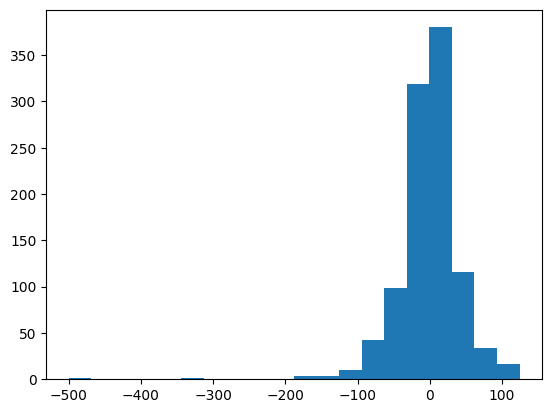

In [ ]:
plt.hist(log_likelihood_lv(x_grid)-pm.reshape(1,-1),bins=20)

(array([845., 150.,  22.,   5.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([2.30965454e-02, 5.00381223e+01, 1.00053148e+02, 1.50068174e+02,
        2.00083199e+02, 2.50098225e+02, 3.00113251e+02, 3.50128277e+02,
        4.00143302e+02, 4.50158328e+02, 5.00173354e+02]),
 <BarContainer object of 10 artists>)

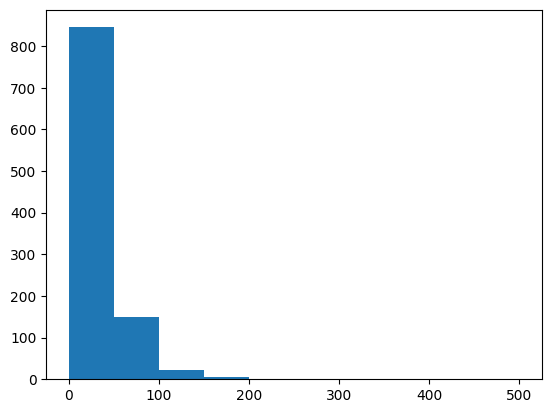

In [ ]:
plt.hist(np.abs(log_likelihood_lv(x_grid).reshape(-1,1)-pm))

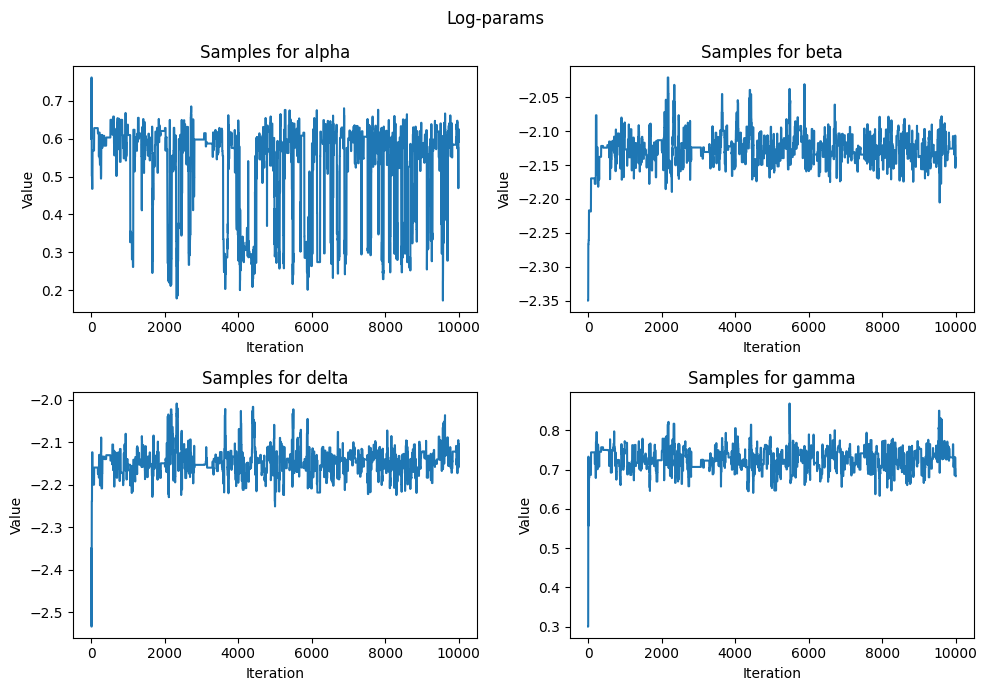

In [69]:
plt.figure(figsize=(10, 7))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(mh_samples[:,i])
    plt.title(f'Samples for {param}')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    #plt.ylim((0,5))
plt.suptitle('Log-params')
plt.tight_layout()
plt.savefig('5-43-26-aug.pdf')
plt.show()

In [70]:
i=2000
q1=np.quantile(mh_samples[i:,:], 0.05, axis=0)
q3=np.quantile(mh_samples[i:,:], 0.95, axis=0)
q2=np.quantile(mh_samples[i:,:], 0.5, axis=0)

In [71]:
print(np.exp(q1),np.exp(q2),np.exp(q3))

[1.30890667 0.11542848 0.111038   1.97588026] [1.78319513 0.11934728 0.11684445 2.06642348] [1.89392756 0.12351093 0.12385758 2.16685618]


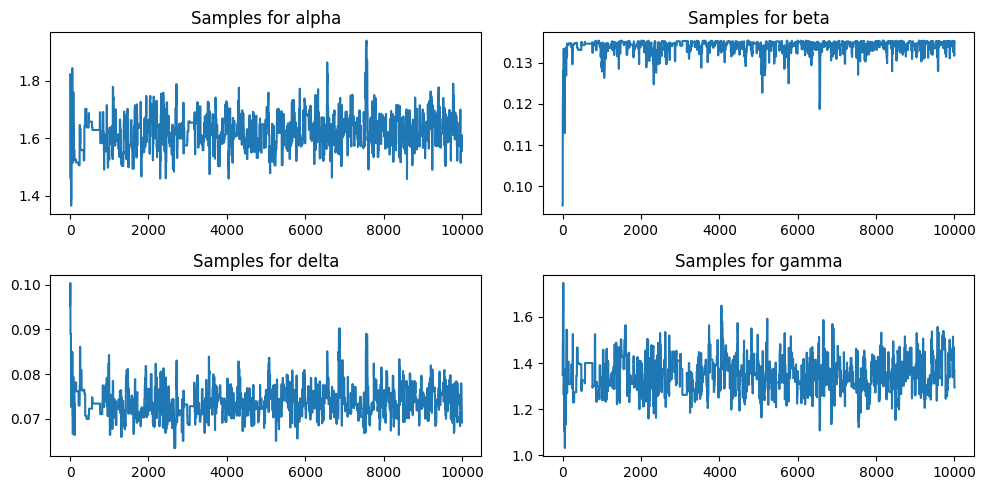

In [ ]:
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(jnp.exp(samples[:, i]))
    plt.title(f'Samples for {param}')
plt.tight_layout()
plt.show()

In [75]:
log_likelihood_lv(jnp.array([q2]))

Array([-28.79491885], dtype=float64)

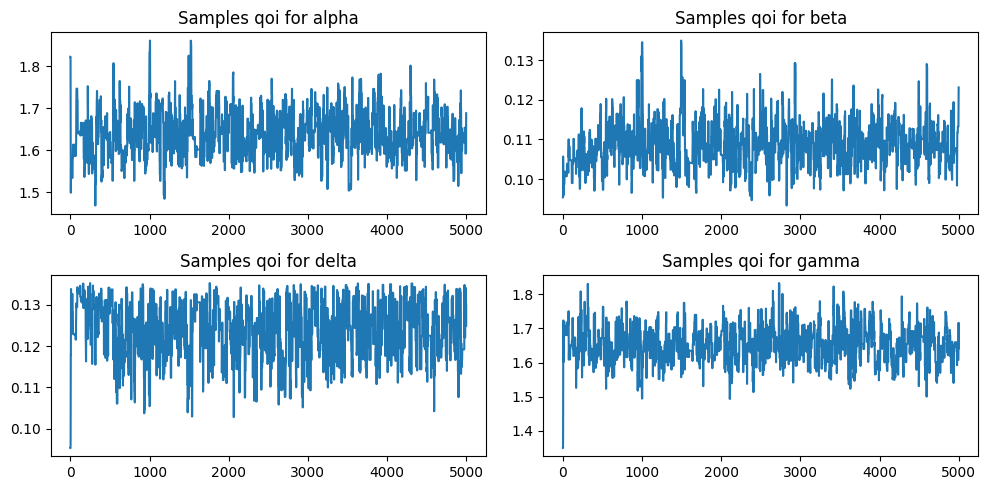

In [ ]:
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(jnp.exp(mh_samples[:, i]))
    plt.title(f'Samples qoi for {param}')
plt.tight_layout()
plt.show()

In [ ]:
np.random.seed(10)
N = 100
mh_samples=np.zeros((N,4))
mh_samples[0,0]=0.25
mh_samples[0,1]=-0.75
mh_samples[0,2]=-0.75
mh_samples[0,3]=0.1

q_means=np.zeros((N,4))
q_means[0] = mh_samples[0]
q_cov = np.eye(4)*0.1
D = gpx.Dataset(params_current, y_current)

posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
latent_dist = posterior.predict(jnp.array([mh_samples[0]]), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)
m_now = predictive_dist.mean()
v_now = predictive_dist.stddev()
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    x_prop =  mh_samples[i-1]+(np.random.uniform(0,1,4) - 0.5)* [0.1,0.1,0.1,0.1] * 5.0 #[0.1,0.01,0.01,0.1]
  else:
    x_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  x_now = mh_samples[i-1]
  # find mean and variance at proposal and prev point
  #m,v = gpmh_eval_posterior(x_current,y_current,x_prop,x_now,key,obs_stddev)
  #m,v = gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev,D)
  m_prop,v_prop = gpmh_eval_posterior_2d(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev,D)
  m,v=get_it_2d(posterior,params_current,x_prop,x_now,m_now,v_now,key,obs_stddev,D,m_prop,v_prop)
  print('step',i,np.exp(log_epsilon_gamma(m,v,u)),np.exp(log_epsilon_gamma_pen(m,v,u)),jnp.exp(expected1(m,v)))
  print('Current',x_now,'proposed',x_prop)
  #print(m,v,jnp.log(u))
  #errors[i-1,0]= jnp.exp(expected1(m,v))
  #errors[i-1]= np.exp(log_epsilon_gamma(m,v,u))
# here implement penalty
  # sample from normal with this mean and variance
  #qoi = np.mean(np.random.normal(0,1,100))*np.sqrt(v)+m - 0.5*v/100
  #qoi= m-0.5*v
  qoi = np.random.normal(0,1,1)*np.sqrt(v)+m - 0.5*v
  print(qoi,m,v,jnp.log(u))
  if qoi >= jnp.log(u):
    mh_samples[i] = x_prop
    m_now = m_prop
    v_now = v_prop
  else:
    mh_samples[i] = mh_samples[i-1]
  #qois[i-1]=qoi



  0%|          | 0/1000 [00:00<?, ?it/s]

step 1 [[0.47241233]] [[0.52120234]] 5.76377523680396
Current [ 0.25 -0.75 -0.75  0.1 ] proposed [ 0.38566032 -0.98962403 -0.68317588  0.22440194]
[[-1.76851118]] [[-0.64425751]] [[0.95201803]] -0.6961376228735829
step 2 [[0.01129478]] [[0.00717896]] 0.05792420700456564
Current [ 0.25 -0.75 -0.75  0.1 ] proposed [ 0.38026536 -0.91544458 -0.95583009  0.19267991]
[[1.23342885]] [[2.2289834]] [[0.86482545]] -0.047727715263522215
step 3 [[0.01980545]] [[0.00584497]] 2.1164033535997837
Current [ 0.38026536 -0.91544458 -0.95583009  0.19267991] proposed [ 0.13223949 -0.90934845 -0.79951961  0.24894294]
[[-2.4042036]] [[-2.44566056]] [[0.70669457]] -0.3260690930511996
step 4 [[0.00136654]] [[5.46758867e-06]] 0.027091006246320465
Current [ 0.38026536 -0.91544458 -0.95583009  0.19267991] proposed [ 0.48755325 -0.8941724  -1.13474507  0.12935029]
[[2.02427107]] [[2.36861046]] [[0.39470297]] -0.3943269457789687
step 5 [[0.09443396]] [[0.10716341]] 2.1711414277449537
Current [ 0.48755325 -0.8941724

(array([871.,  68.,  32.,  14.,   6.,   5.,   2.,   1.,   0.,   1.]),
 array([2.30618890e-06, 2.38628473e+01, 4.77256924e+01, 7.15885374e+01,
        9.54513825e+01, 1.19314227e+02, 1.43177073e+02, 1.67039918e+02,
        1.90902763e+02, 2.14765608e+02, 2.38628453e+02]),
 <BarContainer object of 10 artists>)

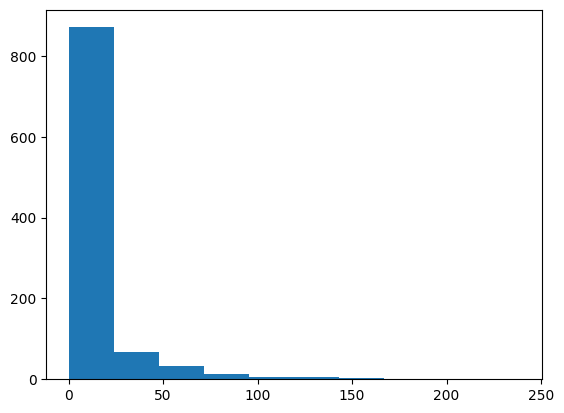

In [ ]:
plt.hist(np.abs(log_likelihood_lv(test_points)-p_mean),bins=10)


In [ ]:
q_means

array([[ 0.6       , -2.35      , -2.35      ,  0.3       ],
       [ 0.6       , -2.35      , -2.35      ,  0.3       ],
       [ 0.6       , -2.35      , -2.35      ,  0.3       ],
       ...,
       [ 0.68020374, -2.12671036, -2.03173034,  0.18167437],
       [ 0.68021486, -2.12669627, -2.0317174 ,  0.18164514],
       [ 0.68022598, -2.1266822 , -2.03170448,  0.18161594]])

In [74]:
#np.log(jnp.array([true_params])
latent_dist = posterior.predict(jnp.array([q2]), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)

p_mean = predictive_dist.mean()#.reshape(-1,1)
p_std = predictive_dist.stddev()#.reshape(-1,1)
p_mean

Array([21.48629852], dtype=float64)

In [ ]:
log_likelihood_lv(jnp.array([q_means[-1,:]]))

Array([-30.8407174], dtype=float64)

In [73]:
latent_dist = posterior.predict(jnp.log(jnp.array([true_params])), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)

p_mean = predictive_dist.mean()#.reshape(-1,1)
p_std = predictive_dist.stddev()#.reshape(-1,1)
p_mean

Array([-47.29014891], dtype=float64)

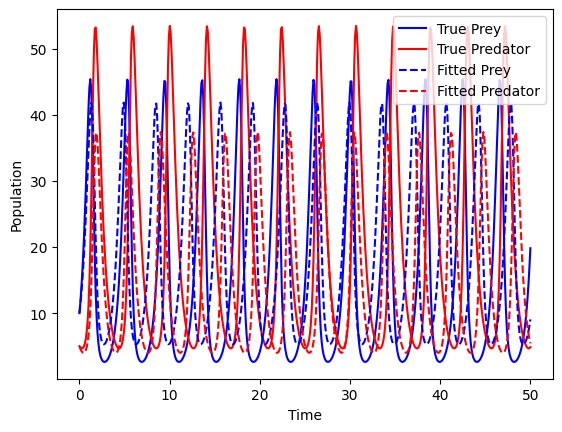

In [72]:
fitted_model = integrate_model(np.exp(q2), t, initial_conditions)
#print(np.exp(best_params))
plt.figure()
plt.plot(t, data[:, 0], 'b-', label='True Prey')
plt.plot(t, data[:, 1], 'r-', label='True Predator')
plt.plot(t, fitted_model[:, 0], 'b--', label='Fitted Prey')
plt.plot(t, fitted_model[:, 1], 'r--', label='Fitted Predator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

In [ ]:
import jax.numpy as jnp
from jax import jit, vmap

# Sample arrays
array_a = jnp.array([[1, 2], [3, 4], [5, 6], [7, 8]])
array_b = jnp.array([[3, 4], [7, 8]])


def remove_matching_rows(array_a, array_b):
    # Define a function to compare each row of array_a with all rows of array_b
    def is_not_in_b(row):
        return jnp.all(jnp.any(jnp.not_equal(array_b, row), axis=1))

    # Vectorize the comparison function
    vmap_is_not_in_b = vmap(is_not_in_b)

    # Apply the comparison to each row of array_a
    mask = vmap_is_not_in_b(array_a)

    # Use the mask to filter out matching rows
    #print(np.array(mask))
    filtered_array = array_a[mask]
    return filtered_array

# Remove matching rows
result = remove_matching_rows(test_points, params_current)
print("Filtered Array A:")
print(result)


# 2d

In [ ]:
from jax import vmap
from jax.experimental.ode import odeint

In [ ]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha, beta, delta, gamma = params

    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
@jit
def log_likelihood_lv(log_params):#, t, data, initial_conditions):
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets
    params=jnp.exp(log_params)
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)

    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)

    # Compute the error and log-likelihood for each parameter set
    errors = data - models

    sigma=10000
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma) + 10.
    return log_likelihoods

# Example data
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([[1.0, 0.05,1.0,0.1], [2.0, 0.1,2.0,0.1],[1.1,1.1,1.1,1.1]])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-14.69543755 -15.44237586 -15.27233806]


In [ ]:
# This removes the terms that don't depend on x_new
def loss_fast2d(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)


    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_std_new = predictive_dist.stddev()#.reshape(-1,1)

    latent_dist = posterior.predict(x_grid, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)
    p_std = predictive_dist.stddev().reshape(-1,1)
    p_mean = predictive_dist.mean().reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)
    print(np.shape(p_std_new),np.shape(p_std),np.shape(p_mean),np.shape(C))
    tau2 = C**2/(p_std_new.T**2 + obs_stddev**2)
    print(np.shape(tau2))
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)
    print(np.shape(log_loss))
    return(log_loss)

In [ ]:
# define x current and y_current
params_current =  jnp.array([[1.0, 0.05,1.0,0.1], [2.0, 0.1,2.0,0.1],[0.1,0.1,0.1,0.1],[-1.5,-1.5,-1.5,-1.5],[1.5,1.5,1.5,1.5]])
params_current = jnp.array(np.random.uniform([-2,-3,-3,-2],[2,1,1,2],(40,4)))
params_current=round(params_current,1)
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))
# set up empty mh_samples
N = 500
mh_samples=np.zeros((N,4))
mh_samples[0,0]=0.0
mh_samples[0,1]=-1.0
mh_samples[0,2]=-1.0
mh_samples[0,3]=0.0
# define max_ieter
max_iter= 50
#define test points
x1_range = jnp.arange(start = -2., stop = 2., step = 0.75)
x2_range = jnp.arange(start = -3., stop = 1., step = 0.75)
x3_range = jnp.arange(start = -3., stop = 1., step = 0.75)
x4_range = jnp.arange(start = -2., stop = 2., step = 0.75)

x1_gridvalues,x2_gridvalues,x3_gridvalues,x4_gridvalues = jnp.meshgrid(x1_range, x2_range,x3_range,x4_range)

x_grid = jnp.vstack([x1_gridvalues.flatten(), x2_gridvalues.flatten(),x3_gridvalues.flatten(),x4_gridvalues.flatten()]).T
x_grid=jnp.array(np.random.uniform([-2,-3,-3,-2],[2,1,1,2],(1000,4)))
#x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
'''
x1_range = jnp.arange(start = -2., stop = 2., step = 1.)
x2_range = jnp.arange(start = -3., stop = 2., step = 1.)
x3_range = jnp.arange(start = -3., stop = 2., step = 1.)
x4_range = jnp.arange(start = -2., stop = 2., step = 1.)

x1_gridvalues,x2_gridvalues,x3_gridvalues,x4_gridvalues = jnp.meshgrid(x1_range, x2_range,x3_range,x4_range)
test_points = jnp.vstack([x1_gridvalues.flatten(), x2_gridvalues.flatten(),x3_gridvalues.flatten(),x4_gridvalues.flatten()]).T
'''
# here we generate testpoints uniformly in the box
test_points=round(jnp.array(np.random.uniform([-2,-3,-3,-2],[2,1,1,2],(500,4))),1)
epsilon = 0.3
obs_stddev=1e-3
proposal='uniform'

In [ ]:
from sklearn.metrics import pairwise_distances
def remove_close_rows(arr1, arr2, threshold=1e-6):
    # Compute the distance between each pair of rows
    distances = pairwise_distances(arr1,arr2)
    #print(distances)

    # Check if any distance is below the threshold for each row in arr1
    is_close = jnp.any(distances < threshold, axis=1)

    # Keep rows that are not close to any row in arr2
    result = arr1[~is_close]

    return result

# Example usage
arr1 = jnp.array([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
arr2 = jnp.array([[1.0, 2.0], [7.0, 8.0]])

filtered_arr1 = remove_close_rows(arr1, arr2)
print(filtered_arr1)

[[3. 4.]
 [5. 6.]]


In [ ]:
m = 0
max_iter= 50
while m < max_iter:
  #test_points= jnp.array([testpt for testpt in np.array(round(test_points,1)) if testpt not in np.array(params_current)])
  #test_points=jnp.array(remove_matching_rows(round(test_points,1),round(params_current,1)))
  #print(test_points)
  test_points= remove_close_rows(test_points,params_current)
  #print(test_points)
  test_point_utilities = loss_fast2d(params_current, y_current, test_points, x_grid, key, obs_stddev)



  i = jnp.argmin(jnp.array(test_point_utilities))
  x_new = test_points[i]
  print(x_new)
  #y_new = log_likelihood_lv(x_new)
  params_current = jnp.vstack([params_current, x_new])
  #params_current = params_current.sort(axis=0)
  y_current =log_likelihood_lv(params_current).reshape(-1,1)


  m+=1

  0%|          | 0/1000 [00:00<?, ?it/s]

(450,) (1000, 1) (1000, 1) (1000, 450)
(1000, 450)
(450,)
[ 1.  -1.3  0.6  1.3]


  0%|          | 0/1000 [00:00<?, ?it/s]

XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 133, in _run_once
  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
  File "<ipython-input-45-4ba94cefb123>", line 9, in <cell line: 3>
  File "<ipython-input-23-d1ffdfd7767b>", line 19, in loss_fast2d
  File "<ipython-input-7-a8b78f381472>", line 31, in fit_gp
  File "/usr/local/lib/python3.10/dist-packages/jaxtyping/_decorator.py", line 522, in wrapped_fn
  File "/usr/local/lib/python3.10/dist-packages/jaxtyping/_decorator.py", line 449, in wrapped_fn_impl
  File "/usr/local/lib/python3.10/dist-packages/gpjax/fit.py", line 172, in fit
  File "/usr/local/lib/python3.10/dist-packages/jaxtyping/_decorator.py", line 522, in wrapped_fn
  File "/usr/local/lib/python3.10/dist-packages/jaxtyping/_decorator.py", line 449, in wrapped_fn_impl
  File "/usr/local/lib/python3.10/dist-packages/gpjax/scan.py", line 165, in vscan
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/traceback_util.py", line 179, in reraise_with_filtered_traceback
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lax/control_flow/loops.py", line 287, in scan
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lax/control_flow/loops.py", line 1262, in scan_bind
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/core.py", line 2788, in bind
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/core.py", line 425, in bind_with_trace
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/core.py", line 913, in process_primitive
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/dispatch.py", line 87, in apply_primitive
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/traceback_util.py", line 179, in reraise_with_filtered_traceback
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/pjit.py", line 298, in cache_miss
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/pjit.py", line 176, in _python_pjit_helper
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/core.py", line 2788, in bind
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/core.py", line 425, in bind_with_trace
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/core.py", line 913, in process_primitive
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/pjit.py", line 1488, in _pjit_call_impl
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/pjit.py", line 1471, in call_impl_cache_miss
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/pjit.py", line 1427, in _pjit_call_impl_python
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/profiler.py", line 335, in wrapper
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/pxla.py", line 1205, in __call__
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py", line 2518, in _wrapped_callback
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py", line 2466, in _wrapped_callback
  File "/usr/local/lib/python3.10/dist-packages/jax/experimental/host_callback.py", line 1163, in wrapped_callback
  File "/usr/local/lib/python3.10/dist-packages/jax/experimental/host_callback.py", line 1277, in _outside_call_run_callback
  File "/usr/local/lib/python3.10/dist-packages/jax/experimental/host_callback.py", line 784, in __call__
  File "/usr/local/lib/python3.10/dist-packages/jaxtyping/_decorator.py", line 524, in wrapped_fn
  File "/usr/local/lib/python3.10/dist-packages/jaxtyping/_decorator.py", line 449, in wrapped_fn_impl
  File "/usr/local/lib/python3.10/dist-packages/gpjax/scan.py", line 130, in _update_tqdm
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1431, in set_postfix
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1347, in refresh
  File "/usr/local/lib/python3.10/dist-packages/tqdm/notebook.py", line 171, in display
  File "/usr/local/lib/python3.10/dist-packages/traitlets/traitlets.py", line 729, in __set__
  File "/usr/local/lib/python3.10/dist-packages/traitlets/traitlets.py", line 718, in set
  File "/usr/local/lib/python3.10/dist-packages/traitlets/traitlets.py", line 1501, in _notify_trait
  File "/usr/local/lib/python3.10/dist-packages/ipywidgets/widgets/widget.py", line 685, in notify_change
  File "/usr/local/lib/python3.10/dist-packages/ipywidgets/widgets/widget.py", line 554, in send_state
  File "/usr/local/lib/python3.10/dist-packages/ipywidgets/widgets/widget.py", line 817, in _send
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/comm/comm.py", line 122, in send
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/comm/comm.py", line 66, in _publish_msg
  File "/usr/local/lib/python3.10/dist-packages/jupyter_client/session.py", line 753, in send
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py", line 262, in send_multipart
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py", line 212, in send_multipart
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py", line 203, in schedule
  File "/usr/local/lib/python3.10/dist-packages/zmq/sugar/socket.py", line 620, in send
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 

In [ ]:
def gpmh_eval_posterior_2d(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  #x_eval = x_eval
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(jnp.array([x_eval[1]]), train_data=D)

  predictive_dist = posterior.likelihood(latent_dist)

  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  #C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval,v)
  return m,v

In [ ]:
def get_it_2d(posterior,x_current,x_prop,x_now,m_now,v_now,key,obs_stddev, D,m,v):
  x_eval = jnp.vstack([x_now,x_prop])

  #x_eval = x_eval.reshape(-1,1)
  C = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[1]]), posterior)
  #C1 = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[0]]), posterior)
  #C2 = two_point_covariance(x_current, jnp.array([x_eval[1]]), jnp.array([x_eval[1]]), posterior)
  #print(C,C1,C2,v_now**2-posterior.likelihood.obs_stddev**2,v**2-posterior.likelihood.obs_stddev**2)
  #print(m,x_eval)
  return m-m_now,v**2 + v_now**2 - 2*C-2*posterior.likelihood.obs_stddev**2

In [ ]:
N = 3000
mh_samples=np.zeros((N,4))
mh_samples[0,0]=0.25
mh_samples[0,1]=-0.75
mh_samples[0,2]=-0.75
mh_samples[0,3]=0.1
D = gpx.Dataset(params_current, y_current)

posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
latent_dist = posterior.predict(jnp.array([mh_samples[0]]), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)
m_now = predictive_dist.mean()
v_now = predictive_dist.stddev()
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    x_prop =  mh_samples[i-1]+(np.random.uniform(0,1,4) - 0.5)*[0.1,0.05,0.05,0.1]*5
  else:
    x_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  x_now = mh_samples[i-1]
  # find mean and variance at proposal and prev point
  #m,v = gpmh_eval_posterior(x_current,y_current,x_prop,x_now,key,obs_stddev)
  #m,v = gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev,D)
  m_prop,v_prop = gpmh_eval_posterior_2d(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev,D)
  m,v=get_it_2d(posterior,params_current,x_prop,x_now,m_now,v_now,key,obs_stddev,D,m_prop,v_prop)
  print('step',i,np.exp(log_epsilon_gamma(m,v,u)),np.exp(log_epsilon_gamma_pen(m,v,u)),jnp.exp(expected1(m,v)))
  print('Current',x_now,'proposed',x_prop)
  #print(m,v,jnp.log(u))
  #errors[i-1,0]= jnp.exp(expected1(m,v))
  #errors[i-1]= np.exp(log_epsilon_gamma(m,v,u))
# here implement penalty
  # sample from normal with this mean and variance
  #qoi = np.mean(np.random.normal(0,1,100))*np.sqrt(v)+m - 0.5*v/100
  #qoi= m-0.5*v
  qoi = np.random.normal(0,1,1)*np.sqrt(v)+m - 0.5*v
  print(qoi,m,v,jnp.log(u))
  if qoi >= jnp.log(u):
    mh_samples[i] = x_prop
    m_now = m_prop
    v_now = v_prop
  else:
    mh_samples[i] = mh_samples[i-1]
  #qois[i-1]=qoi



  0%|          | 0/1000 [00:00<?, ?it/s]

step 1 [[0.28032435]] [[0.73954855]] 6.192752240897043
Current [ 0.25 -0.75 -0.75  0.1 ] proposed [ 0.29173951 -0.87182762 -0.87296212  0.30008409]
[[0.14094283]] [[-0.43186216]] [[1.3492854]] -1.1775481207674898
step 2 [[0.04172186]] [[0.95637369]] 2.747622551638049
Current [ 0.29173951 -0.87182762 -0.87296212  0.30008409] proposed [ 0.07720085 -0.77452216 -0.86018521  0.34001048]
[[0.08920001]] [[0.42396804]] [[1.10679664]] -1.3751026240482664
step 3 [[0.01522578]] [[0.98522327]] 3.6601276216677707
Current [ 0.07720085 -0.77452216 -0.86018521  0.34001048] proposed [ 0.08867677 -0.79445429 -0.8736762   0.5120098 ]
[[-0.29795516]] [[0.04124123]] [[0.6032475]] -1.6488552023802898
step 4 [[0.17633321]] [[0.84896077]] 6.372343426715851
Current [ 0.08867677 -0.79445429 -0.8736762   0.5120098 ] proposed [ 0.33708257 -0.864398   -0.98426978  0.62508891]
[[-2.4800738]] [[-0.50944586]] [[1.56763124]] -1.8015453615515458
step 5 [[0.41740586]] [[0.67194782]] 6.148840550079355
Current [ 0.0886767

KeyboardInterrupt: 

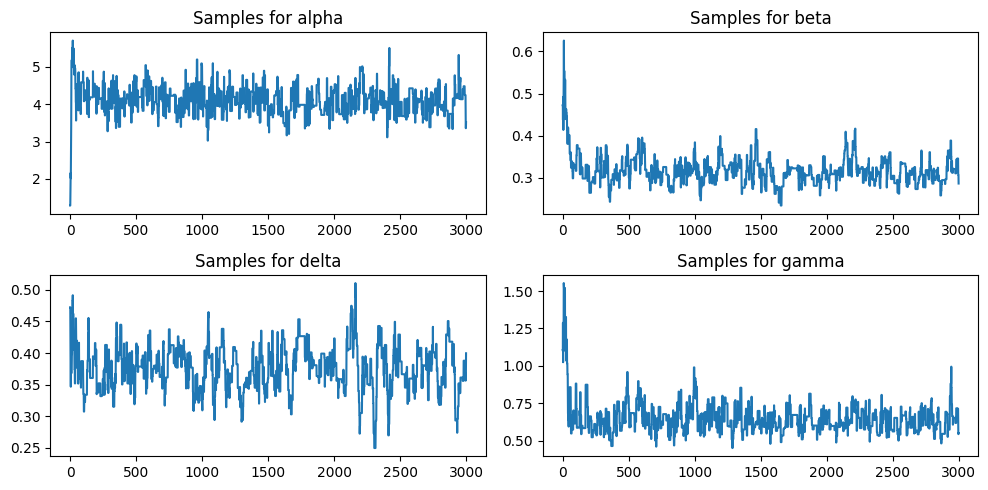

In [ ]:
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(np.exp(mh_samples[:, i]))
    plt.title(f'Samples for {param}')
plt.tight_layout()
plt.show()